## library

In [1]:
setwd('/datd/zorro/projects/NonEpiMutation')
source("/home/zorro/scripts/Rscripts/Seurat_Functions_V5.r")

Warning message:
"package 'gridExtra' was built under R version 4.0.5"
Warning message:
"package 'ggplot2' was built under R version 4.0.5"
Warning message:
"package 'RColorBrewer' was built under R version 4.0.5"
Warning message:
"package 'dplyr' was built under R version 4.0.5"
Warning message:
"package 'tidyr' was built under R version 4.0.5"
Warning message:
"package 'stringr' was built under R version 4.0.5"
Warning message:
"package 'reshape2' was built under R version 4.0.5"
Warning message:
"package 'tibble' was built under R version 4.0.5"
Warning message:
"package 'paletteer' was built under R version 4.0.5"
Warning message:
"package 'Rcpp' was built under R version 4.0.5"
Warning message:
"package 'future' was built under R version 4.0.5"


### Enrichment score calculation

In [24]:
MutationType.list <- list( Germline = c("Germline"), Somatic = c("Somatic"), `Germline+Somatic` = c("Germline","Somatic") )
IMPACT.list <- list( Moderate = c("MODERATE"), High = c("HIGH"), `Moderate+High` = c("MODERATE","HIGH") )

In [25]:
cal_ES_value <- function( X, Y ){
    # Y should be sorted, X should be a character
    sp_num <- sum(Y==X)
    total_num <- length(Y)
    Ph <- 0
    Pm <- 0
    Ph.list <- list()
    Pm.list <- list()
    
    for (i in c(1:total_num)) {
        if (Y[i]==X){
            Ph <- Ph + 1/sp_num
        }else{
            Pm <- Pm + 1/(total_num-sp_num)
        }
        Ph.list[[i]] <- Ph
        Pm.list[[i]] <- Pm
    }
    ES.list <- map2( Ph.list, Pm.list, ~.x-.y )
    ES.out <- max( do.call(c, ES.list) %>% abs )
    return( list(ES.list=ES.list, ES.out=ES.out) )
}

cal_NES_value <- function( ES.result ){
    ES.result[['ES.out']]/mean( do.call( c, ES.result[['ES.list']] ) )
}

cal_p.value_value <- function( X, Y, n=10000 ){
    Raw_Y <- Y
    Raw_ES_result <- cal_ES_value( X, Raw_Y )
    
    New_ES_result_list <- list()
    for (i in 1:n){
        New_Y <- sample( Y, size = length(Y), replace = F )
        New_ES_result_list[[i]] <- cal_ES_value( X, New_Y )
    }
    New_ES_out.vect <- New_ES_result_list %>% map( ., ~.x[["ES.out"]] ) %>% do.call( c, . ) %>% as.vector
    p.value <- sum(New_ES_out.vect > Raw_ES_result[["ES.out"]]) / length( New_ES_out.vect )
    return( p.value )
}

#### raw mutations retained - should change HotspotGene_Somatic_Germline_Mutation_df

In [21]:
HotspotGene_Somatic_Germline_Mutation_df_mod <- HotspotGene_Somatic_Germline_Mutation_df %>% mutate( MajorCelltype = as.vector(MajorCelltype) ) %>% mutate( MajorCelltype = case_when(MajorCelltype=='Stromal_in_norm&cancer'~"Stromal_cell", MajorCelltype=='Immune_in_norm&cancer'~"Immune_cell", MajorCelltype=='Epi_in_norm&adeno'~'Epi_in_norm', MajorCelltype=='Immune_in_norm&adeno'~"Immune_cell", T~MajorCelltype) ) #%>% left_join( NoPBMC_Somatic.Hotspot_And_TMB %>% dplyr::select( Tumor_Sample_Barcode, total_perMB_log ) )

MajorCelltype_order <- c("Cancer_cell","Epi_in_norm","Stromal_cell","Immune_cell")

In [26]:
Mutation_IMPACT_Enrichment_out.list <- structure( map( names(MutationType.list), function(M) {
    structure( map( names(IMPACT.list), function(I) {
        
        HotspotGene_Somatic_Germline_Mutation_df.SampleSummaryOrder  <- HotspotGene_Somatic_Germline_Mutation_df_mod %>% filter( MutationType %in% MutationType.list[[M]], IMPACT %in% IMPACT.list[[I]] ) %>% group_by( Tumor_Sample_Barcode ) %>% summarise( count = n(), Patient = unique(Patient), MergeCelltype = unique(MergeCelltype), MajorCelltype = unique(MajorCelltype), Name = paste( Hugo_Symbol, collapse = "_" ) ) %>% arrange( count ) %>% as.data.frame %>% mutate( Tumor_Sample_Barcode = factor(Tumor_Sample_Barcode , ordered = T, levels = .$Tumor_Sample_Barcode ) ) %>% mutate( label_col = paste0( Patient, " - ", as.vector(MergeCelltype) ) )
        
        structure(map( MajorCelltype_order, function(X) {
            c(
                "NES" = cal_ES_value(X, HotspotGene_Somatic_Germline_Mutation_df.SampleSummaryOrder %>% .$MajorCelltype %>% as.vector %>% rev ) %>% cal_NES_value, #%>% signif( ., 3),
                "P.value" = cal_p.value_value( X, HotspotGene_Somatic_Germline_Mutation_df.SampleSummaryOrder %>% .$MajorCelltype %>% as.vector %>% rev )
            )
        } ), names=MajorCelltype_order)
        
    } ), names = names(IMPACT.list) )
} ), names = names(MutationType.list) )

In [27]:
Mutation_IMPACT_Enrichment_out.list.mod <- Mutation_IMPACT_Enrichment_out.list %>% map( ., transpose ) %>% transpose 
Mutation_IMPACT_Enrichment_out.Matr <- map( names(Mutation_IMPACT_Enrichment_out.list.mod), function(C) {
    
    Mutation_IMPACT_Enrichment_out.list.mod[[C]] %>% map( ., function(X) { do.call( rbind, X ) %>% as.data.frame %>% rownames_to_column( "Impact" ) }) %>% do.call( rbind, . ) %>% rownames_to_column( "Mutation" ) %>% mutate( Mutation = splitName( Mutation, "[.]", 1 ) ) %>% mutate( Celltype = C )
    
} ) %>% do.call( rbind, . ) %>% as.data.frame %>% 
    mutate( Mutation = factor( Mutation, ordered = T, levels = c("Germline","Somatic","Germline+Somatic") ) ) %>% 
    mutate( Impact = factor( Impact, ordered = T, levels = c("Moderate+High","High","Moderate") ) ) %>% 
    mutate( NES = signif(NES, 3) ) %>% mutate( label = ifelse( P.value <= 0.0599, NES, NA ) ) %>%
    mutate( NES = ifelse(NES<(-10), -10, NES) ) %>% mutate( NES = ifelse(NES>(10), 10, NES) )

In [58]:
in_type <- "Cancer_cell"
Mutation_IMPACT_Enrichment_out.Matr %>% filter( Celltype==in_type )

in_type <- "Immune_cell"
Mutation_IMPACT_Enrichment_out.Matr %>% filter( Celltype==in_type )

Mutation,Impact,NES,P.value,Celltype,label
<ord>,<ord>,<dbl>,<dbl>,<chr>,<dbl>
Germline,Moderate,10.00,0.9307,Cancer_cell,NA
Germline,High,-10.00,0.8380,Cancer_cell,NA
Germline,Moderate+High,-10.00,0.9228,Cancer_cell,NA
Somatic,Moderate,2.14,0.0032,Cancer_cell,2.14
Somatic,High,2.13,0.0351,Cancer_cell,2.13
Somatic,Moderate+High,1.77,0.0003,Cancer_cell,1.77
Germline+Somatic,Moderate,3.39,0.1297,Cancer_cell,NA
Germline+Somatic,High,2.38,0.0131,Cancer_cell,2.38
Germline+Somatic,Moderate+High,2.35,0.1078,Cancer_cell,NA


Mutation,Impact,NES,P.value,Celltype,label
<ord>,<ord>,<dbl>,<dbl>,<chr>,<dbl>
Germline,Moderate,-5.66,0.9174,Immune_cell,NA
Germline,High,3.17,0.7746,Immune_cell,NA
Germline,Moderate+High,-10.00,0.8776,Immune_cell,NA
Somatic,Moderate,-2.19,0.0156,Immune_cell,-2.19
Somatic,High,-2.55,0.0138,Immune_cell,-2.55
Somatic,Moderate+High,-1.76,0.0004,Immune_cell,-1.76
Germline+Somatic,Moderate,-2.57,0.5970,Immune_cell,NA
Germline+Somatic,High,-2.85,0.2505,Immune_cell,NA
Germline+Somatic,Moderate+High,-2.52,0.3964,Immune_cell,NA


Warning message:
"Removed 5 rows containing missing values (geom_text)."


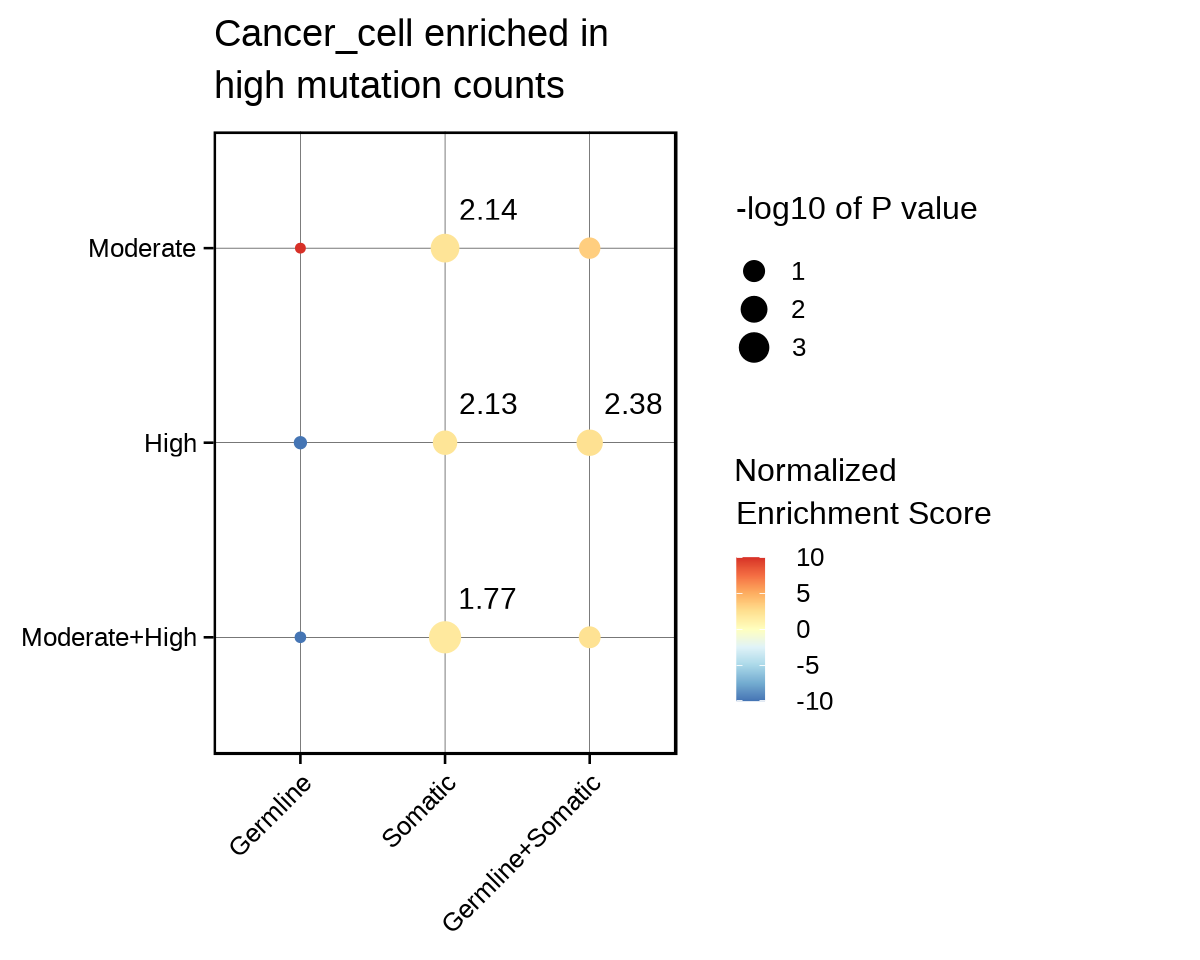

In [59]:
setfig( 10, 8 )

in_type <- "Cancer_cell"
Mutation_IMPACT_Enrichment_out.Matr %>% filter( Celltype==in_type ) %>% ggplot( ., aes( Mutation, Impact, size = -log10(P.value), color = NES ) ) + 
        geom_point( shape = 19 ) + labs( title = paste0(in_type," enriched in\nhigh mutation counts") ) +
        geom_text( aes(label=label), color="black", size = 8, nudge_x = .3, nudge_y = .2 ) +
        scale_color_gradientn( colours = brewer.pal( 9, "RdYlBu" ) %>% rev, limits = c(-10,10), name = "Normalized\nEnrichment Score" ) + 
        scale_size_continuous( range = c(2,8), name = "-log10 of P value" ) +
        theme_linedraw( base_size = 24 ) + theme( axis.title = element_blank(), axis.text.x =  element_text( angle = 45, hjust = 1, vjust = 1 ))

Warning message:
"Removed 9 rows containing missing values (geom_text)."
Warning message:
"Removed 8 rows containing missing values (geom_text)."


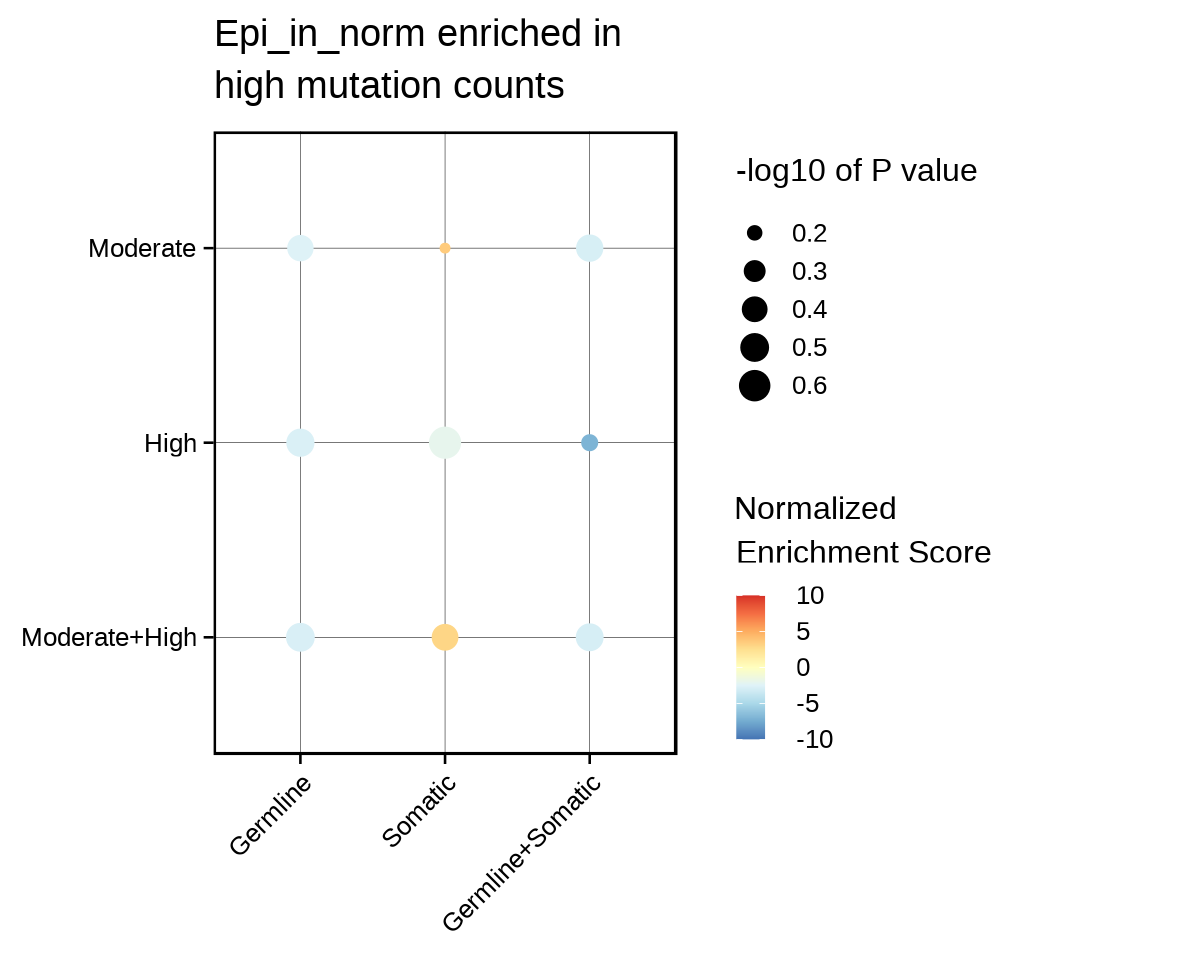

Warning message:
"Removed 6 rows containing missing values (geom_text)."


[[1]]

[[2]]

[[3]]


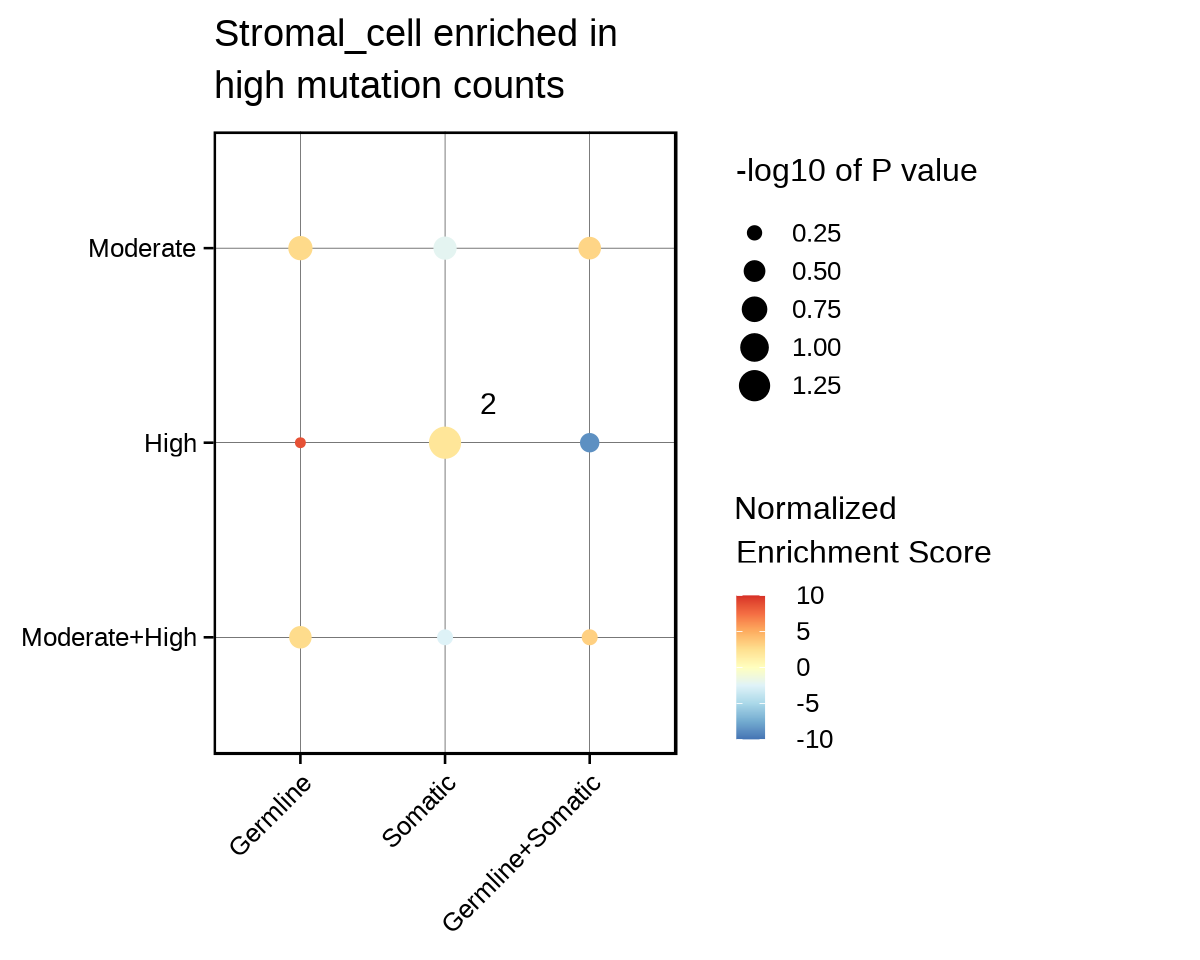

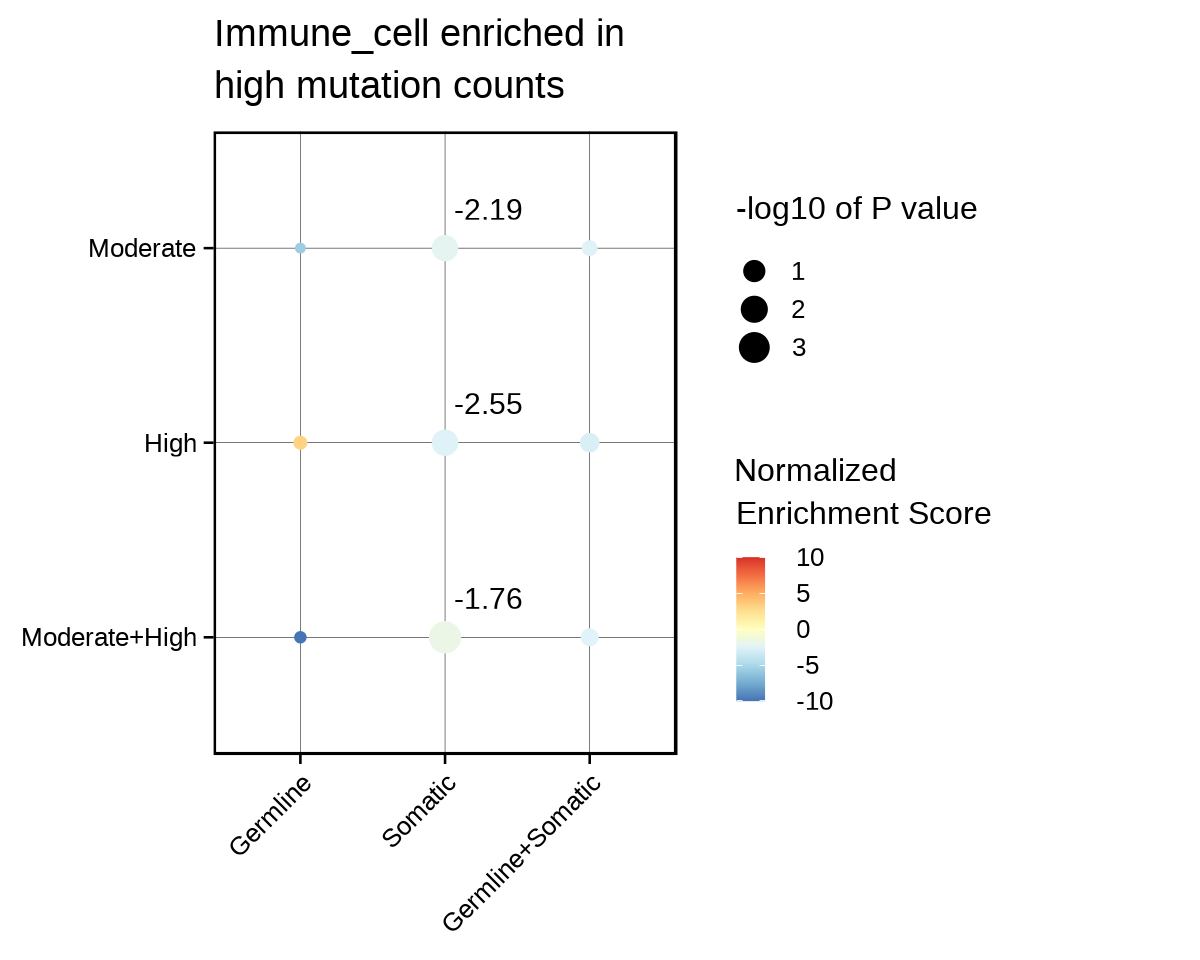

In [60]:
setfig( 10, 8 )

map( MajorCelltype_order[2:4], function(X) {
    
    in_type <- X
    Mutation_IMPACT_Enrichment_out.Matr %>% filter( Celltype==in_type ) %>% ggplot( ., aes( Mutation, Impact, size = -log10(P.value), color = NES ) ) + 
            geom_point( shape = 19 ) + labs( title = paste0(in_type," enriched in\nhigh mutation counts") ) +
            geom_text( aes(label=label), color="black", size = 8, nudge_x = .3, nudge_y = .2 ) +
            scale_color_gradientn( colours = brewer.pal( 9, "RdYlBu" ) %>% rev, limits = c(-10,10), name = "Normalized\nEnrichment Score" ) + 
            scale_size_continuous( range = c(2,8), name = "-log10 of P value" ) +
            theme_linedraw( base_size = 24 ) + theme( axis.title = element_blank(), axis.text.x =  element_text( angle = 45, hjust = 1, vjust = 1 ))
    
} ) #%>% wrap_plots( ., ncol = 2 )

In [62]:
load( "./00.processed.data/03.NoPBMC_Mod_230911/03.NoPBMC_Somatic.Hotspot_And_TMB.rdata" )
MajorCelltype_order <- c("Cancer_cell","Epi_in_norm","Stromal_cell","Immune_cell")

TMB.order <- NoPBMC_Somatic.Hotspot_And_TMB %>% mutate( MajorCelltype = as.vector(MajorCelltype) ) %>% mutate( MajorCelltype = case_when(MajorCelltype=='Stromal_in_norm&cancer'~"Stromal_cell", MajorCelltype=='Immune_in_norm&cancer'~"Immune_cell", MajorCelltype=='Epi_in_norm&adeno'~'Epi_in_norm', MajorCelltype=='Immune_in_norm&adeno'~"Immune_cell", T~MajorCelltype) ) %>% arrange( total_perMB_log ) %>% .$MajorCelltype

In [63]:
MB_Enrichment_out.list <- structure(map( MajorCelltype_order, function(X) {            
    c(
        "NES" = cal_ES_value(X, TMB.order %>% rev ) %>% cal_NES_value, 
        "P.value" = cal_p.value_value( X, TMB.order %>% rev )
    )
} ), names=MajorCelltype_order)
MB_Enrichment_out.matr <- MB_Enrichment_out.list %>% do.call( rbind , . ) %>% apply( ., 2, function(X) signif(X,3) ) %>% as.data.frame
MB_Enrichment_out.matr[ "Cancer_cell", "P.value" ] <- 2.2e-16

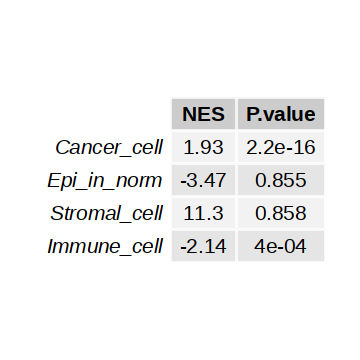

In [64]:
setfig( 3, 3 )
grid.table(MB_Enrichment_out.matr)

#### remove Ca_Epi mutations in TME cells

In [28]:
HotspotGene_Somatic_Germline_Mutation_df_mod <- HotspotGene_Somatic_Germline_Mutation_df %>% mutate( MajorCelltype = as.vector(MajorCelltype) ) %>% mutate( MajorCelltype = case_when(MajorCelltype=='Stromal_in_norm&cancer'~"Stromal_cell", MajorCelltype=='Immune_in_norm&cancer'~"Immune_cell", MajorCelltype=='Epi_in_norm&adeno'~'Epi_in_norm', MajorCelltype=='Immune_in_norm&adeno'~"Immune_cell", T~MajorCelltype) ) #%>% left_join( NoPBMC_Somatic.Hotspot_And_TMB %>% dplyr::select( Tumor_Sample_Barcode, total_perMB_log ) )

MajorCelltype_order <- c("Cancer_cell","Epi_in_norm","Stromal_cell","Immune_cell")

In [29]:
Mutation_IMPACT_Enrichment_out.list <- structure( map( names(MutationType.list), function(M) {
    structure( map( names(IMPACT.list), function(I) {
        
        HotspotGene_Somatic_Germline_Mutation_df.SampleSummaryOrder  <- HotspotGene_Somatic_Germline_Mutation_df_mod %>% filter( MutationType %in% MutationType.list[[M]], IMPACT %in% IMPACT.list[[I]] ) %>% group_by( Tumor_Sample_Barcode ) %>% summarise( count = n(), Patient = unique(Patient), MergeCelltype = unique(MergeCelltype), MajorCelltype = unique(MajorCelltype), Name = paste( Hugo_Symbol, collapse = "_" ) ) %>% arrange( count ) %>% as.data.frame %>% mutate( Tumor_Sample_Barcode = factor(Tumor_Sample_Barcode , ordered = T, levels = .$Tumor_Sample_Barcode ) ) %>% mutate( label_col = paste0( Patient, " - ", as.vector(MergeCelltype) ) )
        
        structure(map( MajorCelltype_order, function(X) {
            c(
                "NES" = cal_ES_value(X, HotspotGene_Somatic_Germline_Mutation_df.SampleSummaryOrder %>% .$MajorCelltype %>% as.vector %>% rev ) %>% cal_NES_value, #%>% signif( ., 3),
                "P.value" = cal_p.value_value( X, HotspotGene_Somatic_Germline_Mutation_df.SampleSummaryOrder %>% .$MajorCelltype %>% as.vector %>% rev )
            )
        } ), names=MajorCelltype_order)
        
    } ), names = names(IMPACT.list) )
} ), names = names(MutationType.list) )

In [30]:
Mutation_IMPACT_Enrichment_out.list.mod <- Mutation_IMPACT_Enrichment_out.list %>% map( ., transpose ) %>% transpose 
Mutation_IMPACT_Enrichment_out.Matr <- map( names(Mutation_IMPACT_Enrichment_out.list.mod), function(C) {
    
    Mutation_IMPACT_Enrichment_out.list.mod[[C]] %>% map( ., function(X) { do.call( rbind, X ) %>% as.data.frame %>% rownames_to_column( "Impact" ) }) %>% do.call( rbind, . ) %>% rownames_to_column( "Mutation" ) %>% mutate( Mutation = splitName( Mutation, "[.]", 1 ) ) %>% mutate( Celltype = C )
    
} ) %>% do.call( rbind, . ) %>% as.data.frame %>% 
    mutate( Mutation = factor( Mutation, ordered = T, levels = c("Germline","Somatic","Germline+Somatic") ) ) %>% 
    mutate( Impact = factor( Impact, ordered = T, levels = c("Moderate+High","High","Moderate") ) ) %>% 
    mutate( NES = signif(NES, 3) ) %>% 
    mutate( P.value = ifelse(P.value==0, NA, P.value), NES = ifelse(P.value==0, NA, NES) ) %>%
    mutate( label = ifelse( P.value <= 0.0599, NES, NA ) ) %>%
    mutate( NES = ifelse(NES<(-10), -10, NES) ) %>% mutate( NES = ifelse(NES>(10), 10, NES) ) 

In [31]:
Mutation_IMPACT_Enrichment_out.Matr

Mutation,Impact,NES,P.value,Celltype,label
<ord>,<ord>,<dbl>,<dbl>,<chr>,<dbl>
Germline,Moderate,10.00,0.9347,Cancer_cell,NA
Germline,High,-10.00,0.8418,Cancer_cell,NA
Germline,Moderate+High,-10.00,0.9193,Cancer_cell,NA
Somatic,Moderate,2.14,0.0036,Cancer_cell,2.14
Somatic,High,2.13,0.0386,Cancer_cell,2.13
Somatic,Moderate+High,1.77,0.0002,Cancer_cell,1.77
Germline+Somatic,Moderate,3.39,0.1309,Cancer_cell,NA
Germline+Somatic,High,2.38,0.0133,Cancer_cell,2.38
Germline+Somatic,Moderate+High,2.35,0.1033,Cancer_cell,NA


Warning message:
"Removed 5 rows containing missing values (geom_text)."


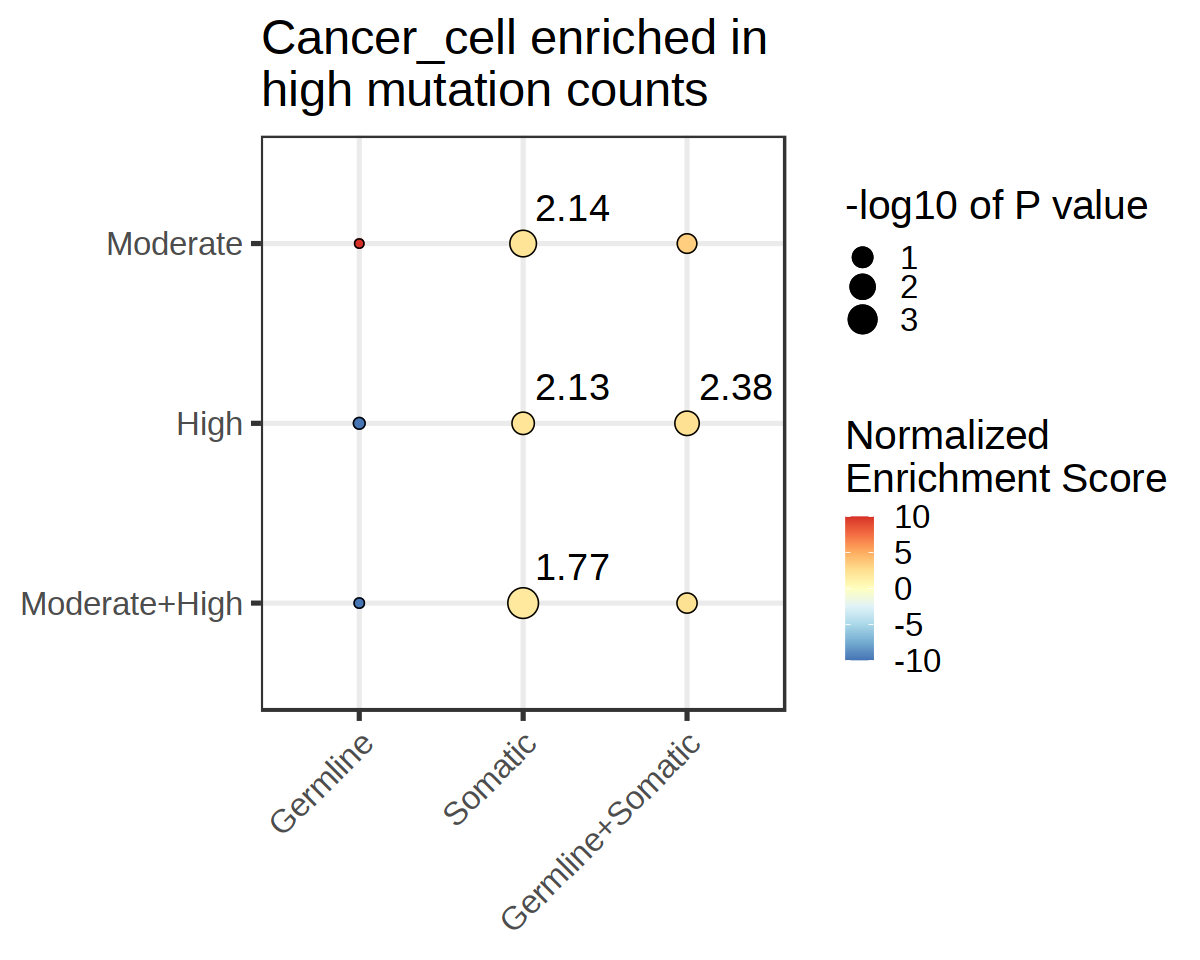

In [32]:
setfig( 10, 8 )

in_type <- "Cancer_cell"
Mutation_IMPACT_Enrichment_out.Matr %>% filter( Celltype==in_type ) %>% ggplot( ., aes( Mutation, Impact, size = -log10(P.value), color = NES ) ) + 
        geom_point( shape = 19 ) + geom_point( shape = 1, color="black" ) + labs( title = paste0(in_type," enriched in\nhigh mutation counts") ) +
        geom_text( aes(label=label), color="black", size = 8, nudge_x = .3, nudge_y = .2 ) +
        scale_color_gradientn( colours = brewer.pal( 9, "RdYlBu" ) %>% rev, limits = c(-10,10), name = "Normalized\nEnrichment Score" ) + 
        scale_size_continuous( range = c(2,8), name = "-log10 of P value" ) +
        theme_bw( base_size = 24 ) + theme( axis.title = element_blank(), axis.text.x =  element_text( angle = 45, hjust = 1, vjust = 1 ))

In [33]:
pdf( "./00.manuscript/05.KeyGenes_And_MultiModel/MutateEnrich_CancerCell_WithGroups_ImpactAndTypes.pdf", 10, 8, useDingbats = F )

setfig( 10, 8 )

in_type <- "Cancer_cell"
Mutation_IMPACT_Enrichment_out.Matr %>% filter( Celltype==in_type ) %>% ggplot( ., aes( Mutation, Impact, size = -log10(P.value), color = NES ) ) + 
        geom_point( shape = 19 ) + geom_point( shape = 1, color="black" ) + labs( title = paste0(in_type," enriched in\nhigh mutation counts") ) +
        geom_text( aes(label=label), color="black", size = 8, nudge_x = .3, nudge_y = .2 ) +
        scale_color_gradientn( colours = brewer.pal( 9, "RdYlBu" ) %>% rev, limits = c(-10,10), name = "Normalized\nEnrichment Score" ) + 
        scale_size_continuous( range = c(2,8), name = "-log10 of P value" ) +
        theme_bw( base_size = 24 ) + theme( axis.title = element_blank(), axis.text.x =  element_text( angle = 45, hjust = 1, vjust = 1 ))

dev.off()

Warning message:
"Removed 5 rows containing missing values (geom_text)."


png 
  2

Warning message:
"Removed 9 rows containing missing values (geom_text)."
Warning message:
"Removed 8 rows containing missing values (geom_text)."


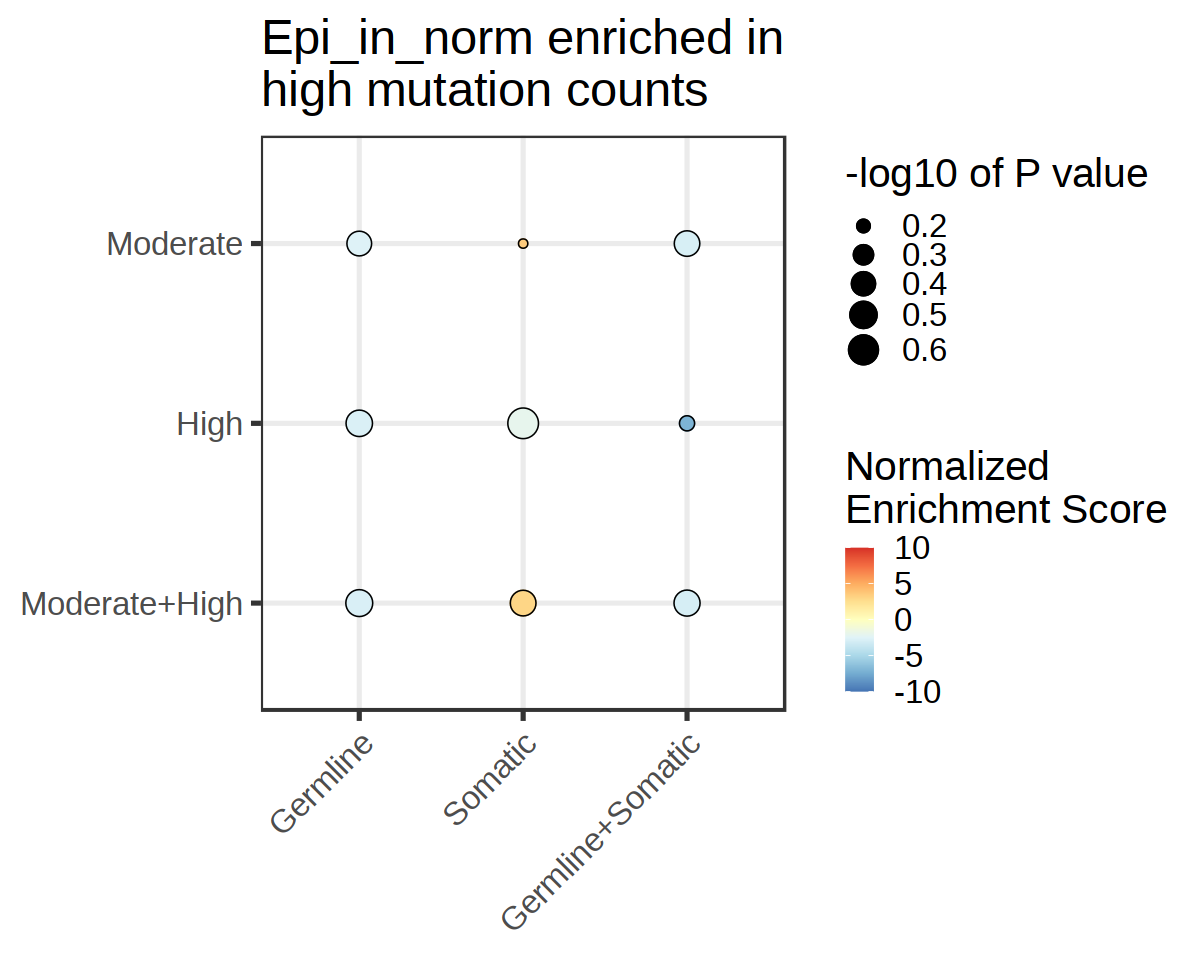

Warning message:
"Removed 6 rows containing missing values (geom_text)."


[[1]]

[[2]]

[[3]]


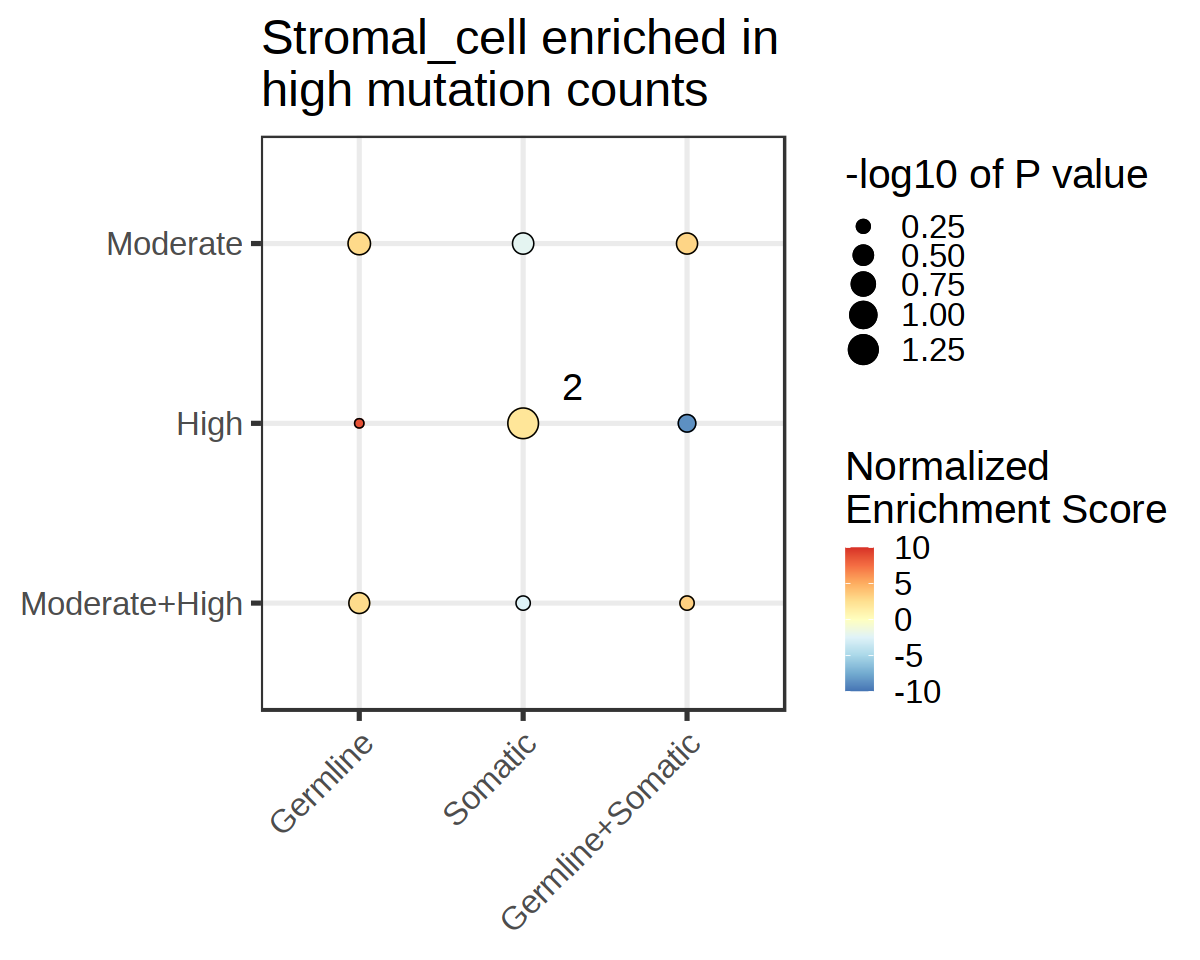

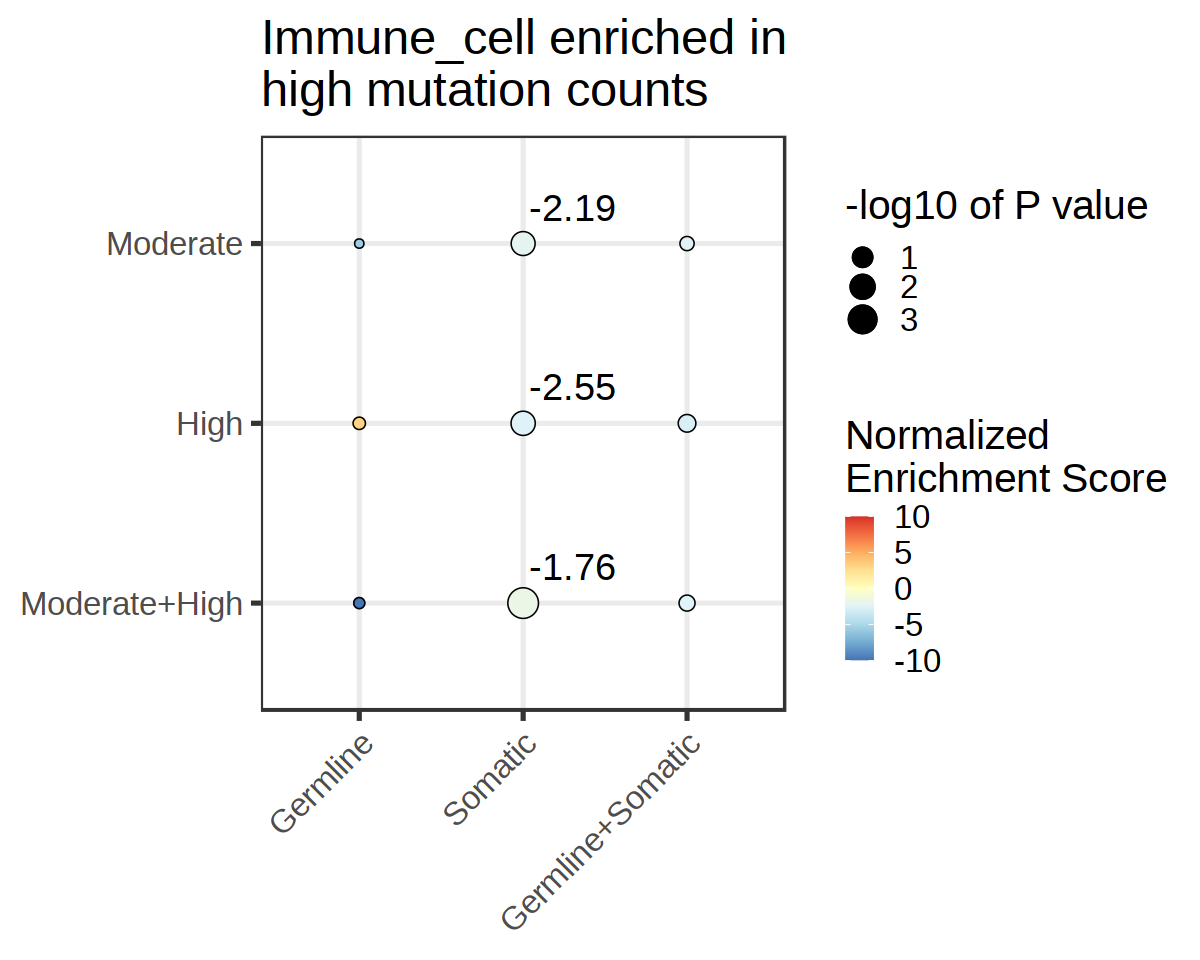

In [34]:
setfig( 10, 8 )

map( MajorCelltype_order[2:4], function(X) {
    
    in_type <- X
    Mutation_IMPACT_Enrichment_out.Matr %>% filter( Celltype==in_type ) %>% ggplot( ., aes( Mutation, Impact, size = -log10(P.value), color = NES ) ) + 
            geom_point( shape = 19 ) + geom_point( shape = 1, color="black" ) + labs( title = paste0(in_type," enriched in\nhigh mutation counts") ) +
            geom_text( aes(label=label), color="black", size = 8, nudge_x = .3, nudge_y = .2 ) +
            scale_color_gradientn( colours = brewer.pal( 9, "RdYlBu" ) %>% rev, limits = c(-10,10), name = "Normalized\nEnrichment Score" ) + 
            scale_size_continuous( range = c(2,8), name = "-log10 of P value" ) +
            theme_bw( base_size = 24 ) + theme( axis.title = element_blank(), axis.text.x =  element_text( angle = 45, hjust = 1, vjust = 1 ))
    
} ) #%>% wrap_plots( ., ncol = 2 )

In [35]:
pdf( "./00.manuscript/05.KeyGenes_And_MultiModel/MutateEnrich_Other3Celltypes_WithGroups_ImpactAndTypes.pdf", 10, 8, useDingbats = F )

setfig( 10, 8 )

map( MajorCelltype_order[2:4], function(X) {
    
    in_type <- X
    Mutation_IMPACT_Enrichment_out.Matr %>% filter( Celltype==in_type ) %>% ggplot( ., aes( Mutation, Impact, size = -log10(P.value), color = NES ) ) + 
            geom_point( shape = 19 ) + geom_point( shape = 1, color="black" ) + labs( title = paste0(in_type," enriched in\nhigh mutation counts") ) +
            geom_text( aes(label=label), color="black", size = 8, nudge_x = .3, nudge_y = .2 ) +
            scale_color_gradientn( colours = brewer.pal( 9, "RdYlBu" ) %>% rev, limits = c(-10,10), name = "Normalized\nEnrichment Score" ) + 
            scale_size_continuous( range = c(2,8), name = "-log10 of P value" ) +
            theme_bw( base_size = 24 ) + theme( axis.title = element_blank(), axis.text.x =  element_text( angle = 45, hjust = 1, vjust = 1 ))
    
} ) #%>% wrap_plots( ., ncol = 2 )

dev.off()

Warning message:
"Removed 9 rows containing missing values (geom_text)."
Warning message:
"Removed 8 rows containing missing values (geom_text)."
Warning message:
"Removed 6 rows containing missing values (geom_text)."


[[1]]

[[2]]

[[3]]


png 
  2

In [36]:
load( "./00.processed.data/03.NoPBMC_Mod_230911/03.NoPBMC_Somatic.Hotspot_And_TMB.rdata"  )
# NoPBMC_Somatic.Hotspot_And_TMB
# NoPBMC_Somatic_HotspotMod.Hotspot_And_TMB
MajorCelltype_order <- c("Cancer_cell","Epi_in_norm","Stromal_cell","Immune_cell")

TMB.order <- NoPBMC_Somatic_HotspotMod.Hotspot_And_TMB %>% mutate( MajorCelltype = as.vector(MajorCelltype) ) %>% mutate( MajorCelltype = case_when(MajorCelltype=='Stromal_in_norm&cancer'~"Stromal_cell", MajorCelltype=='Immune_in_norm&cancer'~"Immune_cell", MajorCelltype=='Epi_in_norm&adeno'~'Epi_in_norm', MajorCelltype=='Immune_in_norm&adeno'~"Immune_cell", T~MajorCelltype) ) %>% arrange( total_perMB_log ) %>% .$MajorCelltype

In [37]:
MB_Enrichment_out.list <- structure(map( MajorCelltype_order, function(X) {            
    c(
        "NES" = cal_ES_value(X, TMB.order %>% rev ) %>% cal_NES_value, 
        "P.value" = cal_p.value_value( X, TMB.order %>% rev )
    )
} ), names=MajorCelltype_order)
MB_Enrichment_out.matr <- MB_Enrichment_out.list %>% do.call( rbind , . ) %>% apply( ., 2, function(X) signif(X,3) ) %>% as.data.frame
MB_Enrichment_out.matr[ "Cancer_cell", "P.value" ] <- 2.2e-16

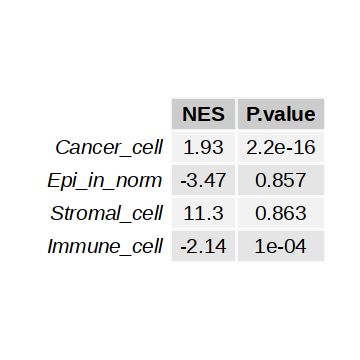

In [38]:
setfig( 3, 3 )
grid.table(MB_Enrichment_out.matr)

In [39]:
pdf( "./00.manuscript/05.KeyGenes_And_MultiModel/MutateEnrich_TMBorder_WithCelltypes.pdf", 3, 3, useDingbats = F )

setfig( 3, 3 )
grid.table(MB_Enrichment_out.matr)

dev.off()

png 
  2

In [61]:
SomaticMutation_IMPACT_Enrichment_Merged.Matr <- rbind(
    Mutation_IMPACT_Enrichment_out.Matr %>% filter( Mutation == "Somatic" ) %>% mutate( Mutation=as.vector(Mutation), Impact=as.vector(Impact) ) %>% dplyr::select(c("Mutation","Celltype","Impact","NES","P.value","label")),
    MB_Enrichment_out.matr %>% rownames_to_column( "Celltype" ) %>% mutate( Mutation="Somatic", Impact = "MutationBurden" ) %>% mutate( label = ifelse( P.value <= 0.0599, NES, NA ) ) %>% dplyr::select(c("Mutation","Celltype","Impact","NES","P.value","label"))
) %>% as.data.frame %>% dplyr::select( -Mutation ) %>% mutate( Celltype = factor( Celltype, ordered = T, levels = c("Cancer_cell","Epi_in_norm","Stromal_cell","Immune_cell") ), Impact = factor( Impact, ordered = T, levels = c("MutationBurden","Moderate","High","Moderate+High") %>% rev ) )

Warning message:
"Removed 7 rows containing missing values (geom_text)."


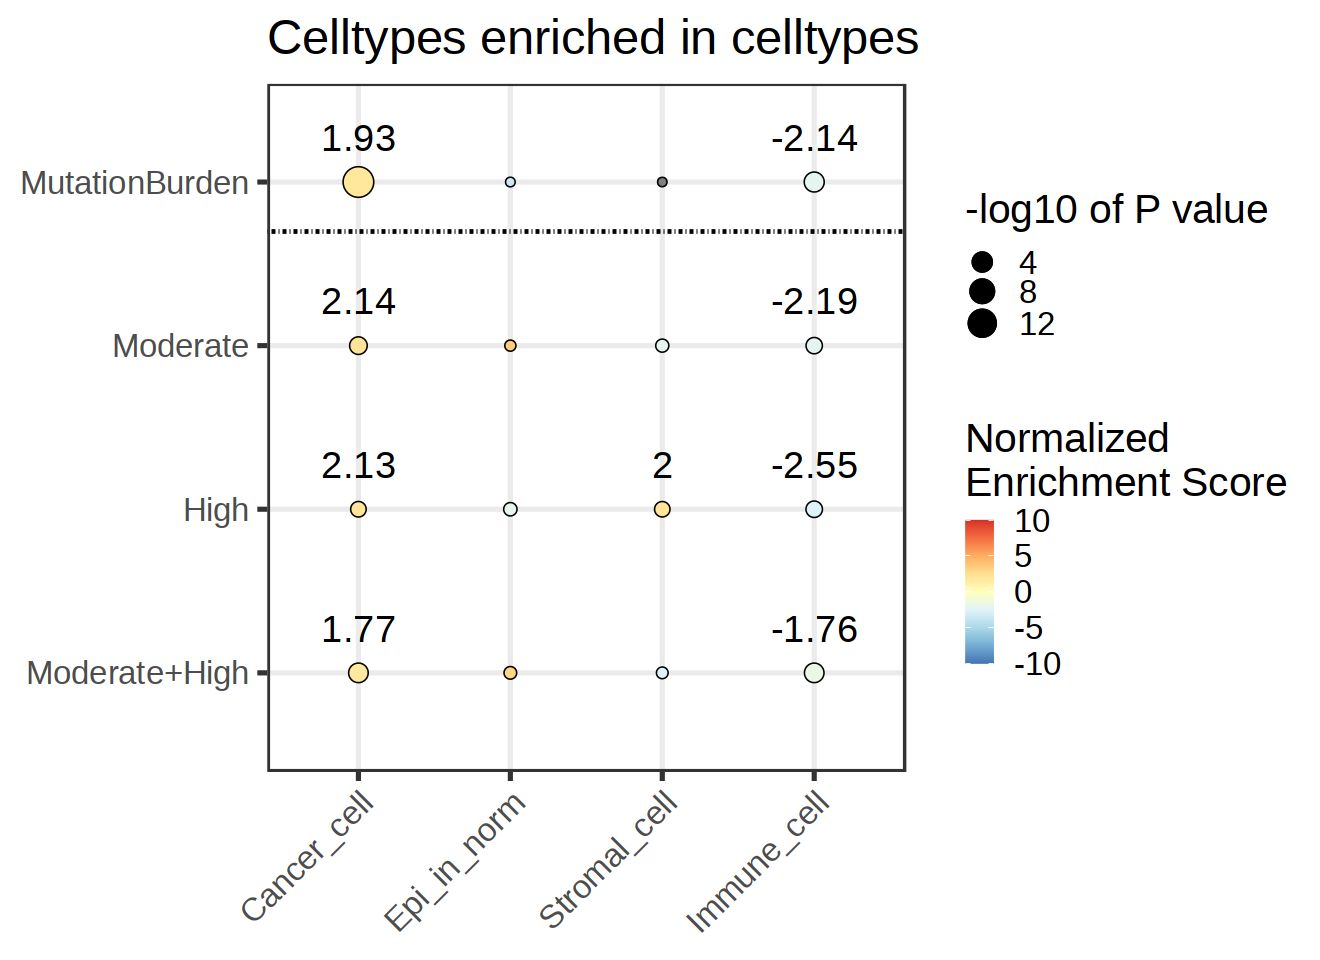

In [70]:
setfig( 11, 8 )

SomaticMutation_IMPACT_Enrichment_Merged.Matr %>% ggplot( ., aes( Celltype, Impact, size = -log10(P.value), color = NES ) ) + 
        geom_point( shape = 19 ) + geom_point( shape = 1, color="black" ) + labs( title = "Celltypes enriched in celltypes" ) +
        geom_text( aes(label=label), color="black", size = 8, nudge_x = 0, nudge_y = .27 ) +
        geom_hline( yintercept = 3.7, linetype = "dotdash", size = 1 ) +
        scale_color_gradientn( colours = brewer.pal( 9, "RdYlBu" ) %>% rev, limits = c(-10,10), name = "Normalized\nEnrichment Score" ) + 
        scale_size_continuous( range = c(2,8), name = "-log10 of P value" ) +
        theme_bw( base_size = 24 ) + theme( axis.title = element_blank(), axis.text.x =  element_text( angle = 45, hjust = 1, vjust = 1 ))

In [13]:
## remove Ca_Epi mutations in TME cells
NoPBMC_Somatic_HotspotMod <- readRDS( "./00.processed.data/03.NoPBMC_Mod_230911/NoPBMC_Somatic_HotspotMod.rds" )
HotspotGene_Somatic_Germline_Mutation_df <- rbind(
    FAP_Somatic@data %>% filter( Hugo_Symbol %in% Hotspot_Genes ) %>% mutate( MutationType = "Somatic" ) %>% dplyr::select( -c("Patient","Tissue","Celltype","MergeCelltype","OutNames","MajorCelltype","unique_id","Patient_unique_id","MainCelltype") ),
    FAP_Germline@data %>% filter( Hugo_Symbol %in% Hotspot_Genes ) %>% mutate( MutationType = "Germline" ),
    NoPBMC_Somatic_HotspotMod@data %>% filter( Hugo_Symbol %in% Hotspot_Genes ) %>% mutate( MutationType = "Somatic" ) %>% dplyr::select( -c("Patient","Tissue","Celltype","MergeCelltype","OutNames","MajorCelltype","unique_id","Patient_unique_id","MainCelltype") ),
    NoPBMC_Germline@data %>% filter( Hugo_Symbol %in% Hotspot_Genes ) %>% mutate( MutationType = "Germline" )
) %>% as.data.frame %>% dplyr::select( c("Hugo_Symbol", "Variant_Classification", "Variant_Type", "dbSNP_RS", "Tumor_Sample_Barcode", "HGVSc", "HGVSp", "HGVSp_Short", "Existing_variation", "IMPACT", "MutationType") ) %>% 
    arrange( Hugo_Symbol, Tumor_Sample_Barcode, desc(MutationType) ) %>% 
    distinct( Hugo_Symbol,Variant_Classification,Variant_Type,dbSNP_RS,Tumor_Sample_Barcode,HGVSc,HGVSp,HGVSp_Short,Existing_variation,IMPACT, .keep_all = T )

HotspotGene_Somatic_Germline_Mutation_df <- rbind(
    HotspotGene_Somatic_Germline_Mutation_df %>% filter( !grepl("Frame",Variant_Classification) ) %>% mutate( HGVSp_Short_=HGVSp_Short ),
    HotspotGene_Somatic_Germline_Mutation_df %>% filter( grepl("Frame",Variant_Classification) ) %>% 
        mutate( type=case_when( grepl("del",HGVSc)~"del", grepl("ins",HGVSc)~"ins", T~"NA" ) ) %>%
        mutate( HGVSp_Short_= ifelse( grepl("_",HGVSp_Short), paste0( splitName(HGVSp_Short,"_",1), type ), 
            ifelse( grepl("[A-z]fs",HGVSp_Short), paste0( splitName(HGVSp_Short,"[A-z]fs",1), type ), paste0( str_replace(HGVSp_Short,"[*]",""), type ) ))) %>% 
        dplyr::select( -type )
    ) %>% as.data.frame %>% mutate( HGVSp_Short_mod= paste0( Hugo_Symbol,"__",HGVSp_Short ) ) %>% dplyr::select( -HGVSp_Short_ ) %>% 
    mutate( Hotspot_site_label = ifelse( HGVSp_Short_mod %in% Hotspot_Genes_df$HGVSp_Short_mod, T, F ) ) %>% 
    left_join( WES.SampleInfo %>% mutate( Tumor_Sample_Barcode = as.vector(Tumor_Sample_Barcode) ) ) %>%
    mutate( Tumor_Sample_Barcode = factor( Tumor_Sample_Barcode, ordered = T, levels = levels(WES.SampleInfo$Tumor_Sample_Barcode) ) ) %>%
    arrange( Hugo_Symbol, Tumor_Sample_Barcode, MutationType )

HotspotGene_Somatic_Germline_Mutation_df %<>% mutate( Genetype = case_when( 
    (Hugo_Symbol %in% Oncogene.vect.raw) & !(Hugo_Symbol %in% TSG.vect.raw)~"Oncogene",
    !(Hugo_Symbol %in% Oncogene.vect.raw) & (Hugo_Symbol %in% TSG.vect.raw)~"Tumor suppressor gene", 
#     !(Hugo_Symbol %in% Oncogene.vect.raw) & !(Hugo_Symbol %in% TSG.vect.raw)~"Undefined",
    T~"Undefined"
) )

HotspotGene_Somatic_Germline_Mutation_df %>% dim

Joining, by = "Tumor_Sample_Barcode"


[1] 5117   21

In [14]:
HotspotGene_Somatic_Germline_MutationQuality.list <-  table(HotspotGene_Somatic_Germline_Mutation_df$MainCelltype, HotspotGene_Somatic_Germline_Mutation_df$MutationType, HotspotGene_Somatic_Germline_Mutation_df$IMPACT ) %>% as.data.frame %>% split( ., .$Var1 ) %>% map( ., ~.x %>% dplyr::select(-Var1) %>% pivot_wider( names_from = "Var2", values_from = "Freq" ) %>% column_to_rownames("Var3") %>% .[c("MODERATE","HIGH"),] )

HotspotGene_Somatic_Germline_MutationQuality.fisher <- map( HotspotGene_Somatic_Germline_MutationQuality.list, function(X) {
    v1 <- X %>% as.matrix %>% as.vector %>% structure( ., names = c("G_M", "G_H", "S_M", "S_H") )
    test <- fisher.test( X )
    v2 <- c( "odd.ratio" = test$estimate[[1]], "p.value" = test$p.value )
    return( c(v1, v2) )
} ) %>% do.call( rbind, . ) %>% as.data.frame

In [15]:
HotspotGene_Somatic_Germline_MutationQuality.fisher

,G_M,G_H,S_M,S_H,odd.ratio,p.value
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Epi_in_norm,744,17,14,7,21.56439,8.869764e-07
Cancer_cell,765,10,50,28,42.32356,1.289216e-23
Stromal_cell,1146,21,8,5,33.58281,3.971368e-06
Immune_cell,2227,59,11,5,17.07861,4.895641e-05


In [16]:
Oncogene_Somatic_Germline_Mutation_df <- rbind(
    FAP_Somatic@data %>% filter( Hugo_Symbol %in% Hotspot_Genes_In_OG ) %>% mutate( MutationType = "Somatic" ) %>% dplyr::select( -c("Patient","Tissue","Celltype","MergeCelltype","OutNames","MajorCelltype","unique_id","Patient_unique_id","MainCelltype") ),
    FAP_Germline@data %>% filter( Hugo_Symbol %in% Hotspot_Genes_In_OG ) %>% mutate( MutationType = "Germline" ),
    NoPBMC_Somatic_HotspotMod@data %>% filter( Hugo_Symbol %in% Hotspot_Genes_In_OG ) %>% mutate( MutationType = "Somatic" ) %>% dplyr::select( -c("Patient","Tissue","Celltype","MergeCelltype","OutNames","MajorCelltype","unique_id","Patient_unique_id","MainCelltype") ),
    NoPBMC_Germline@data %>% filter( Hugo_Symbol %in% Hotspot_Genes_In_OG ) %>% mutate( MutationType = "Germline" )
) %>% as.data.frame %>% dplyr::select( c("Hugo_Symbol", "Variant_Classification", "Variant_Type", "dbSNP_RS", "Tumor_Sample_Barcode", "HGVSc", "HGVSp", "HGVSp_Short", "Existing_variation", "IMPACT", "MutationType") ) %>% 
    arrange( Hugo_Symbol, Tumor_Sample_Barcode, desc(MutationType) ) %>% 
    distinct( Hugo_Symbol,Variant_Classification,Variant_Type,dbSNP_RS,Tumor_Sample_Barcode,HGVSc,HGVSp,HGVSp_Short,Existing_variation,IMPACT, .keep_all = T ) %>% 
    left_join( WES.SampleInfo %>% mutate( Tumor_Sample_Barcode = as.vector(Tumor_Sample_Barcode) ) ) %>%
    mutate( Tumor_Sample_Barcode = factor( Tumor_Sample_Barcode, ordered = T, levels = levels(WES.SampleInfo$Tumor_Sample_Barcode) ) ) %>%
    arrange( Hugo_Symbol, Tumor_Sample_Barcode, MutationType )

TSG_Somatic_Germline_Mutation_df <- rbind(
    FAP_Somatic@data %>% filter( Hugo_Symbol %in% Hotspot_Genes_In_TSG ) %>% mutate( MutationType = "Somatic" ) %>% dplyr::select( -c("Patient","Tissue","Celltype","MergeCelltype","OutNames","MajorCelltype","unique_id","Patient_unique_id","MainCelltype") ),
    FAP_Germline@data %>% filter( Hugo_Symbol %in% Hotspot_Genes_In_TSG ) %>% mutate( MutationType = "Germline" ),
    NoPBMC_Somatic_HotspotMod@data %>% filter( Hugo_Symbol %in% Hotspot_Genes_In_TSG )%>% mutate( MutationType = "Somatic" ) %>% dplyr::select( -c("Patient","Tissue","Celltype","MergeCelltype","OutNames","MajorCelltype","unique_id","Patient_unique_id","MainCelltype") ),
    NoPBMC_Germline@data %>% filter( Hugo_Symbol %in% Hotspot_Genes_In_TSG ) %>% mutate( MutationType = "Germline" )
) %>% as.data.frame %>% dplyr::select( c("Hugo_Symbol", "Variant_Classification", "Variant_Type", "dbSNP_RS", "Tumor_Sample_Barcode", "HGVSc", "HGVSp", "HGVSp_Short", "Existing_variation", "IMPACT", "MutationType") ) %>% 
    arrange( Hugo_Symbol, Tumor_Sample_Barcode, desc(MutationType) ) %>% 
    distinct( Hugo_Symbol,Variant_Classification,Variant_Type,dbSNP_RS,Tumor_Sample_Barcode,HGVSc,HGVSp,HGVSp_Short,Existing_variation,IMPACT, .keep_all = T ) %>% 
    left_join( WES.SampleInfo %>% mutate( Tumor_Sample_Barcode = as.vector(Tumor_Sample_Barcode) ) ) %>%
    mutate( Tumor_Sample_Barcode = factor( Tumor_Sample_Barcode, ordered = T, levels = levels(WES.SampleInfo$Tumor_Sample_Barcode) ) ) %>%
    arrange( Hugo_Symbol, Tumor_Sample_Barcode, MutationType )

Joining, by = "Tumor_Sample_Barcode"
Joining, by = "Tumor_Sample_Barcode"


In [17]:
Oncogene_Somatic_Germline_Mutation_df %>% dim
TSG_Somatic_Germline_Mutation_df %>% dim

[1] 948  18

[1] 1529   18

In [18]:
Oncogene_Somatic_Germline_MutationQuality.list <- table(Oncogene_Somatic_Germline_Mutation_df$MainCelltype, Oncogene_Somatic_Germline_Mutation_df$MutationType, Oncogene_Somatic_Germline_Mutation_df$IMPACT ) %>% as.data.frame %>% split( ., .$Var1 ) %>% map( ., ~.x %>% dplyr::select(-Var1) %>% pivot_wider( names_from = "Var2", values_from = "Freq" ) %>% column_to_rownames("Var3") %>% .[c("MODERATE","HIGH"),] )

Oncogene_Somatic_Germline_MutationQuality.fisher <- map( Oncogene_Somatic_Germline_MutationQuality.list, function(X) {
    v1 <- X %>% as.matrix %>% as.vector %>% structure( ., names = c("G_M", "G_H", "S_M", "S_H") )
    test <- fisher.test( X )
    v2 <- c( "odd.ratio" = test$estimate[[1]], "p.value" = test$p.value )
    return( c(v1, v2) )
} ) %>% do.call( rbind, . ) %>% as.data.frame

TSG_Somatic_Germline_MutationQuality.list <-  table(TSG_Somatic_Germline_Mutation_df$MainCelltype, TSG_Somatic_Germline_Mutation_df$MutationType, TSG_Somatic_Germline_Mutation_df$IMPACT ) %>% as.data.frame %>% split( ., .$Var1 ) %>% map( ., ~.x %>% dplyr::select(-Var1) %>% pivot_wider( names_from = "Var2", values_from = "Freq" ) %>% column_to_rownames("Var3") %>% .[c("MODERATE","HIGH"),] )

TSG_Somatic_Germline_MutationQuality.fisher <- map( TSG_Somatic_Germline_MutationQuality.list, function(X) {
    v1 <- X %>% as.matrix %>% as.vector %>% structure( ., names = c("G_M", "G_H", "S_M", "S_H") )
    test <- fisher.test( X )
    v2 <- c( "odd.ratio" = test$estimate[[1]], "p.value" = test$p.value )
    return( c(v1, v2) )
} ) %>% do.call( rbind, . ) %>% as.data.frame

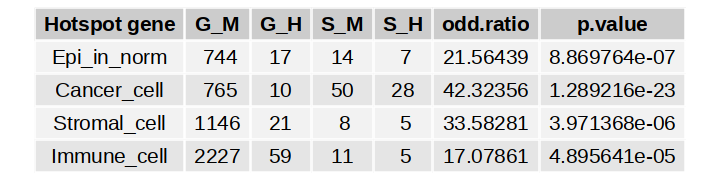

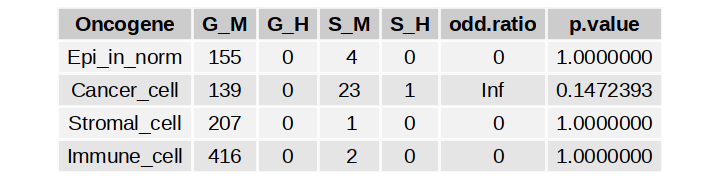

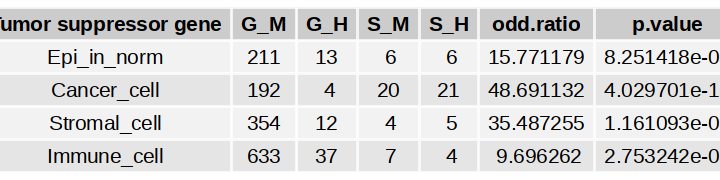

In [19]:
setfig( 6, 1.5 )
grid.newpage()
HotspotGene_Somatic_Germline_MutationQuality.fisher %>% rownames_to_column("Hotspot gene") %>% grid.table( ., row=NULL )
grid.newpage()
Oncogene_Somatic_Germline_MutationQuality.fisher %>% rownames_to_column("Oncogene") %>% grid.table( ., row=NULL )
grid.newpage()
TSG_Somatic_Germline_MutationQuality.fisher %>% rownames_to_column("Tumor suppressor gene") %>% grid.table( ., row=NULL )

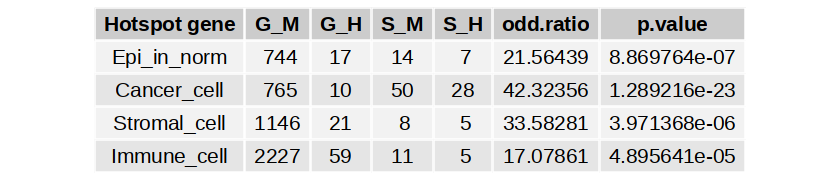

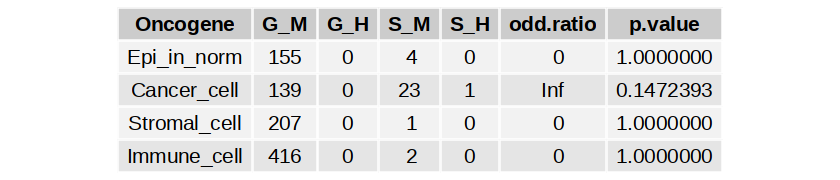

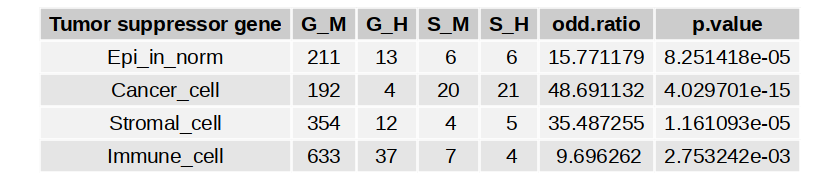

In [22]:
setfig( 7, 1.5 )
grid.newpage()
HotspotGene_Somatic_Germline_MutationQuality.fisher %>% rownames_to_column("Hotspot gene") %>% grid.table( ., row=NULL )
grid.newpage()
Oncogene_Somatic_Germline_MutationQuality.fisher %>% rownames_to_column("Oncogene") %>% grid.table( ., row=NULL )
grid.newpage()
TSG_Somatic_Germline_MutationQuality.fisher %>% rownames_to_column("Tumor suppressor gene") %>% grid.table( ., row=NULL )

In [23]:
pdf( "./00.manuscript/05.KeyGenes_And_MultiModel/MutateEnrich_ImpactAndMutatetype_Celltypes_table.pdf", 7, 1.5, useDingbats = F )

setfig( 7, 1.5 )
grid.newpage()
HotspotGene_Somatic_Germline_MutationQuality.fisher %>% rownames_to_column("Hotspot gene") %>% grid.table( ., row=NULL )
grid.newpage()
Oncogene_Somatic_Germline_MutationQuality.fisher %>% rownames_to_column("Oncogene") %>% grid.table( ., row=NULL )
grid.newpage()
TSG_Somatic_Germline_MutationQuality.fisher %>% rownames_to_column("Tumor suppressor gene") %>% grid.table( ., row=NULL )

dev.off()

png 
  2

In [24]:
HotspotGene_Somatic_Germline_Mutation_df %>% filter( MutationType=="Somatic" ) %>% dim

[1] 128  21

In [25]:
Oncogene_Somatic_Germline_Mutation_df %>% filter( MutationType=="Somatic" ) %>% dim
TSG_Somatic_Germline_Mutation_df %>% filter( MutationType=="Somatic" ) %>% dim

[1] 31 18

[1] 73 18

Warning message:
"Removed 3 rows containing missing values (geom_point)."
Warning message:
"Removed 3 rows containing missing values (geom_point)."


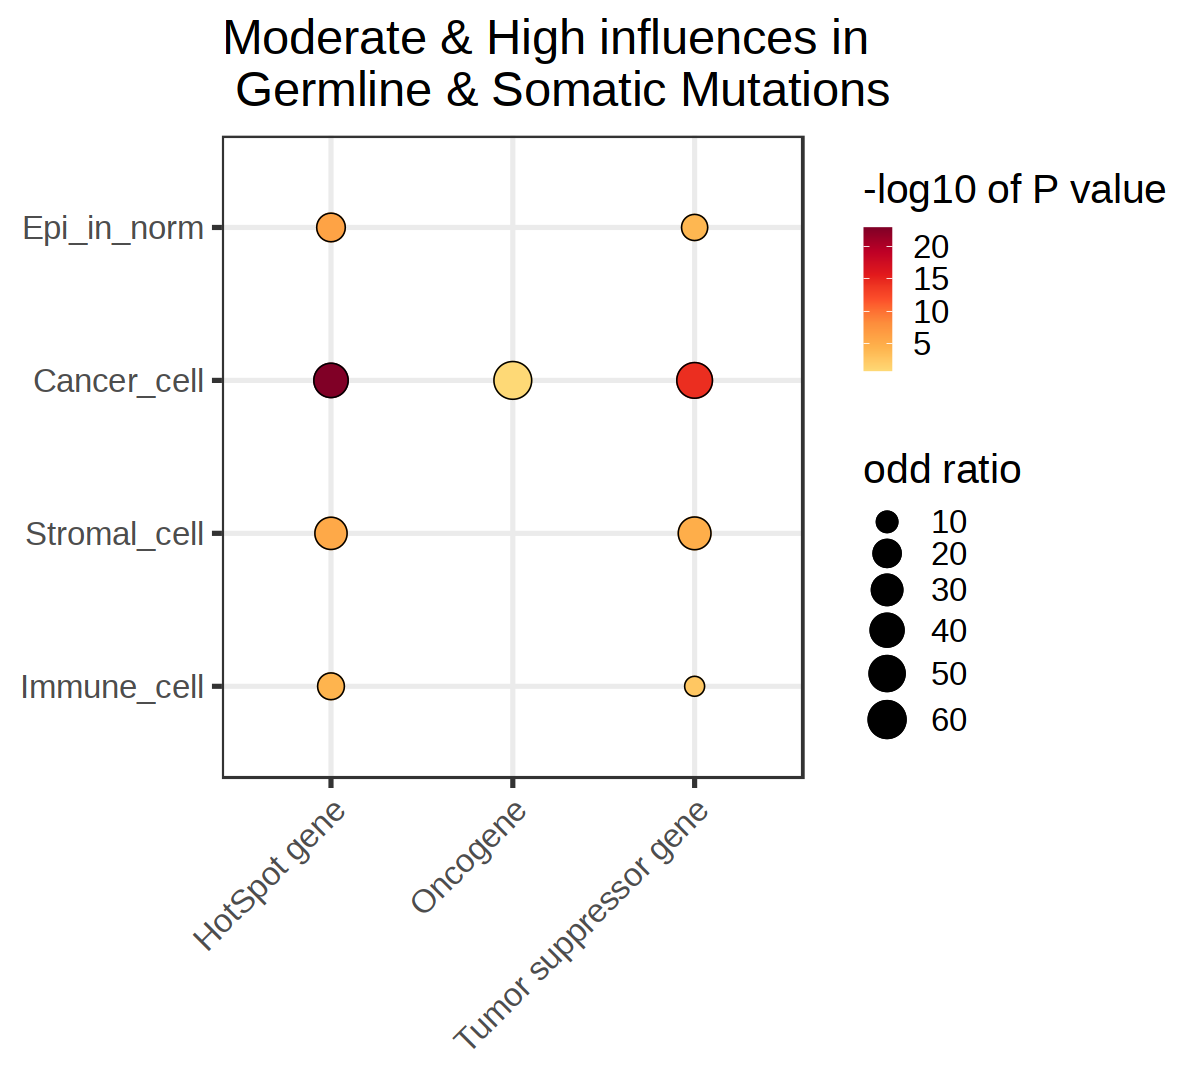

In [26]:
setfig( 10, 9 )

list(
    HotspotGene_Somatic_Germline_MutationQuality.fisher %>% mutate( type = "HotSpot gene" ) %>% rownames_to_column( "MainCelltype" ),
    Oncogene_Somatic_Germline_MutationQuality.fisher %>% mutate( type = "Oncogene" ) %>% rownames_to_column( "MainCelltype" ),
    TSG_Somatic_Germline_MutationQuality.fisher %>% mutate( type = "Tumor suppressor gene" ) %>% rownames_to_column( "MainCelltype" )
) %>% do.call( rbind, . ) %>% as.data.frame %>% mutate( MainCelltype = factor(MainCelltype, ordered = T, levels = MainCelltype_order %>% rev) ) %>%
    mutate( odd.ratio = ifelse( odd.ratio==0, NA, odd.ratio ), p.value = ifelse( p.value>=.9, NA, p.value ) ) %>%
    mutate( odd.ratio = ifelse( odd.ratio==Inf, 60, odd.ratio ) ) %>%
    ggplot( ., aes( type, MainCelltype, size = odd.ratio, color = -log10(p.value) ) ) + 
        geom_point( shape = 19 ) + geom_point( shape = 1, color = "black" ) + labs( title = "Moderate & High influences in\n Germline & Somatic Mutations" ) +
        scale_color_gradientn( colours = brewer.pal( 9, "YlOrRd" )[3:9], name = "-log10 of P value" ) + scale_size_continuous( range = c(5,10), name = "odd ratio" ) +
        theme_bw( base_size = 24 ) + theme( axis.title = element_blank(), axis.text.x =  element_text( angle = 45, hjust = 1, vjust = 1 ))

In [27]:
pdf( "./00.manuscript/05.KeyGenes_And_MultiModel/MutateEnrich_ImpactAndMutatetype_Celltypes_dotplot.pdf", 10, 9, useDingbats = F )

setfig( 10, 9 )

list(
    HotspotGene_Somatic_Germline_MutationQuality.fisher %>% mutate( type = "HotSpot gene" ) %>% rownames_to_column( "MainCelltype" ),
    Oncogene_Somatic_Germline_MutationQuality.fisher %>% mutate( type = "Oncogene" ) %>% rownames_to_column( "MainCelltype" ),
    TSG_Somatic_Germline_MutationQuality.fisher %>% mutate( type = "Tumor suppressor gene" ) %>% rownames_to_column( "MainCelltype" )
) %>% do.call( rbind, . ) %>% as.data.frame %>% mutate( MainCelltype = factor(MainCelltype, ordered = T, levels = MainCelltype_order %>% rev) ) %>%
    mutate( odd.ratio = ifelse( odd.ratio==0, NA, odd.ratio ), p.value = ifelse( p.value>=.9, NA, p.value ) ) %>%
    mutate( odd.ratio = ifelse( odd.ratio==Inf, 60, odd.ratio ) ) %>%
    ggplot( ., aes( type, MainCelltype, size = odd.ratio, color = -log10(p.value) ) ) + 
        geom_point( shape = 19 ) + geom_point( shape = 1, color = "black" ) + labs( title = "Moderate & High influences in\n Germline & Somatic Mutations" ) +
        scale_color_gradientn( colours = brewer.pal( 9, "YlOrRd" )[3:9], name = "-log10 of P value" ) + scale_size_continuous( range = c(5,10), name = "odd ratio" ) +
        theme_bw( base_size = 24 ) + theme( axis.title = element_blank(), axis.text.x =  element_text( angle = 45, hjust = 1, vjust = 1 ))

dev.off()

Warning message:
"Removed 3 rows containing missing values (geom_point)."
Warning message:
"Removed 3 rows containing missing values (geom_point)."


png 
  2

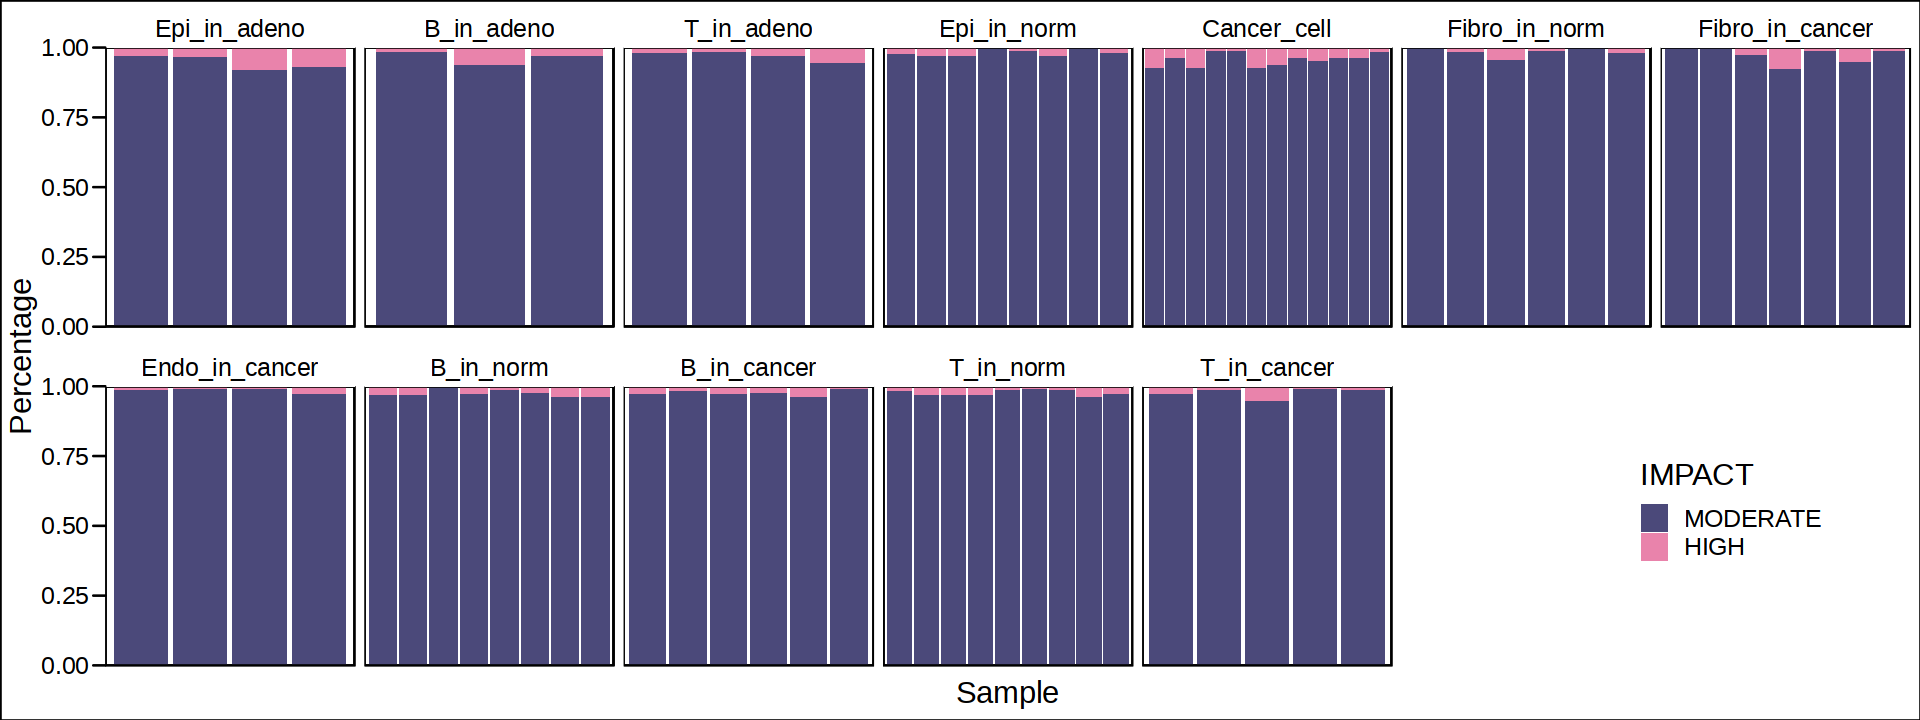

In [28]:
setfig( 16, 6 )

HotspotGene_Somatic_Germline_Mutation_df %>% dplyr::select( Tumor_Sample_Barcode, IMPACT, MergeCelltype ) %>% mutate( Tumor_Sample_Barcode=as.vector(Tumor_Sample_Barcode) ) %>% ggplot( ., aes( Tumor_Sample_Barcode, fill=IMPACT) ) + geom_bar( stat = "count", position = "fill" ) + facet_wrap( ~MergeCelltype, ncol = 7, scales = "free_x" ) + scale_y_continuous(expand = c(0, 0)) + scale_fill_manual( values = IMPACT_colors ) + labs( x="Sample", y="Percentage" ) + theme_base( base_size = 18 ) + theme( axis.text.x = element_blank(), axis.ticks.x = element_blank(), legend.position = c(.9,.25) )

In [29]:
pdf( "./00.manuscript/05.KeyGenes_And_MultiModel/ImpactDistribution_in_subtypes_barplot.pdf", 16, 6, useDingbats = F )

setfig( 16, 6 )

HotspotGene_Somatic_Germline_Mutation_df %>% dplyr::select( Tumor_Sample_Barcode, IMPACT, MergeCelltype ) %>% mutate( Tumor_Sample_Barcode=as.vector(Tumor_Sample_Barcode) ) %>% ggplot( ., aes( Tumor_Sample_Barcode, fill=IMPACT) ) + geom_bar( stat = "count", position = "fill" ) + facet_wrap( ~MergeCelltype, ncol = 7, scales = "free_x" ) + scale_y_continuous(expand = c(0, 0)) + scale_fill_manual( values = IMPACT_colors ) + labs( x="Sample", y="Percentage" ) + theme_base( base_size = 18 ) + theme( axis.text.x = element_blank(), axis.ticks.x = element_blank(), legend.position = c(.9,.25) )

dev.off()

png 
  2

In [44]:
load( "./00.processed.data/05.MultiInfo_Somatic_Germline_Mutation.rdata" )

Somatic_HGVSp_terms <- HotspotGene_Somatic_Germline_Mutation_df %>% filter( MutationType=="Somatic" ) %>% filter( MajorCelltype!="Cancer_cell" ) %>% .$HGVSp_Short_mod
Somatic_HGVSp_terms <- table(Somatic_HGVSp_terms) %>% sort(.,decreasing = T) 
Somatic_HGVSp_terms <- names(Somatic_HGVSp_terms)#[ Somatic_HGVSp_terms>1 ]

Somatic_HGVSp_terms

[1] "APC__p.R1450*"         "APC__p.D1422Ifs*51"    "KRAS__p.G12V"         
 [4] "NOTCH2__p.A21T"        "PTPRS__p.T1171P"       "APC__p.A1485Yfs*27"   
 [7] "APC__p.E1554*"         "APC__p.E868Kfs*43"     "APC__p.G502_A504del"  
[10] "APC__p.L1488_A1492del" "ARID1A__p.Q2219*"      "ATRX__p.T1358Dfs*4"   
[13] "BRCA2__p.P412T"        "BRD4__p.P1001S"        "CREBBP__p.R370*"      
[16] "DICER1__p.L1065V"      "DNMT1__p.V42M"         "DNMT1__p.Y641H"       
[19] "DNMT3A__p.H873*"       "EP300__p.N1206K"       "GLI1__p.K79R"         
[22] "GNAS__p.R265H"         "IGF1R__p.A674V"        "KMT2C__p.H703Q"       
[25] "KMT2C__p.I707S"        "KMT2C__p.Y4280H"       "NSD1__p.H1991Q"       
[28] "NSD1__p.K513R"         "PBRM1__p.P1424Q"       "PTPRT__p.D99Y"        
[31] "RAD52__p.D337N"        "RBM10__p.A717V"        "RECQL4__p.R1182P"     
[34] "RXRA__p.P35Q"          "SDHA__p.G260W"         "SETD2__p.K1135N"      
[37] "SOX9__p.P247Afs*5"     "STK19__p.R52H"         "TCF7L2__p.E51*"       
[40] "TCF7L2__p.P202L"       "TCF7L2__p.W156*"       "TP53__p.H178Pfs*3"    
[43] "TP53__p.R248Q"         "TP53__p.S392Ffs*79"

Joining, by = "Tumor_Sample_Barcode"


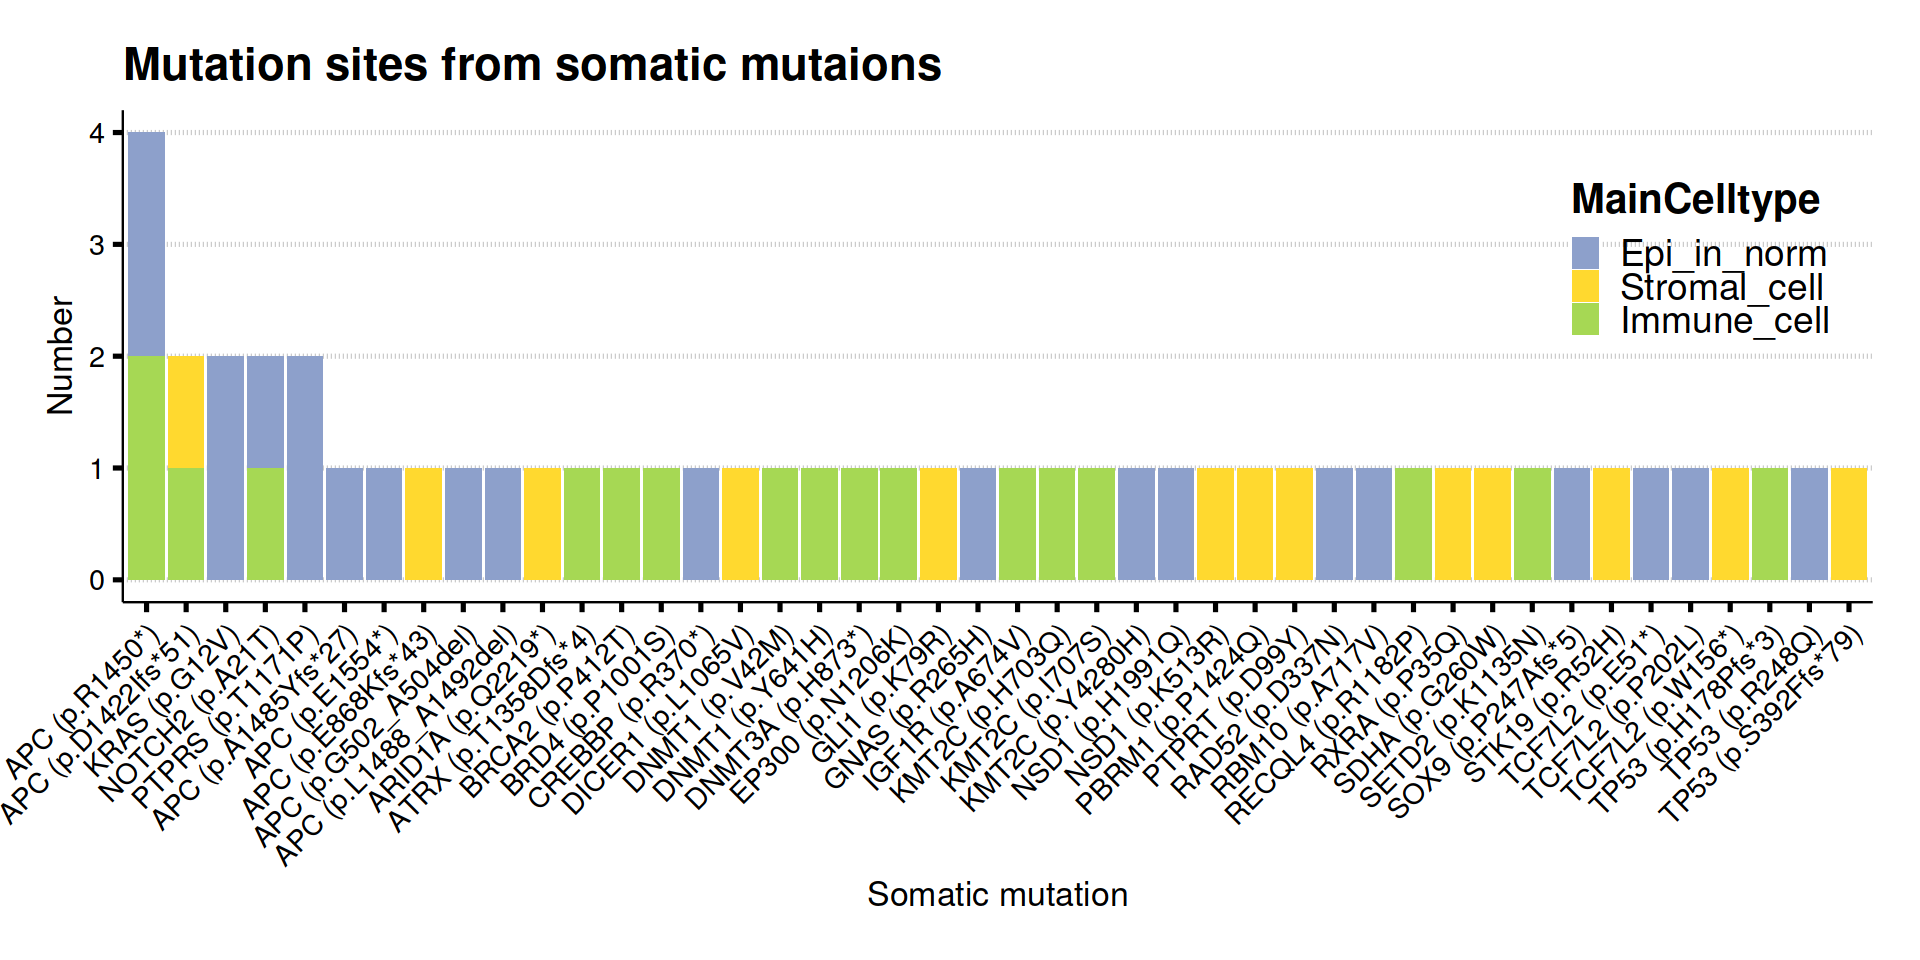

In [45]:
setfig( 16, 8 )

Somatic_HGVSp_terms_df <- HotspotGene_Somatic_Germline_Mutation_df %>% left_join( WES.SampleInfo %>% dplyr::select( Tumor_Sample_Barcode, MainCelltype ) %>% mutate( Tumor_Sample_Barcode = as.vector(Tumor_Sample_Barcode) ) ) %>% filter( HGVSp_Short_mod %in% Somatic_HGVSp_terms, MajorCelltype!="Cancer_cell" ) %>% mutate( label = paste0(str_replace_all(HGVSp_Short_mod, "__", " (" ),")") ) %>% mutate( HGVSp_Short_mod = factor(HGVSp_Short_mod, ordered = T, levels = Somatic_HGVSp_terms) ) %>% arrange( HGVSp_Short_mod )

Somatic_HGVSp_terms_df %>% ggplot( ., aes( HGVSp_Short_mod, fill = MainCelltype ) ) + geom_bar( stat = "count" ) + scale_fill_manual( values = MainCelltype_colors[ names(MainCelltype_colors)!="Cancer_cell" ] ) + labs( title = "Mutation sites from somatic mutaions", x = "Somatic mutation", y = "Number" ) + scale_x_discrete( label = Somatic_HGVSp_terms_df$label %>% unique ) + theme_clean( base_size = 24 ) + theme( axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1), legend.background = element_blank(), plot.background = element_blank(), legend.position = c(.9,.7), plot.margin = unit(c(1,1,1,1),"cm") )

In [46]:
pdf( "./00.manuscript/05.KeyGenes_And_MultiModel/MutationSites_SomaticMutation_Celltypes_Number_barplot.pdf", 16, 8, useDingbats = F )

setfig( 16, 8 )

Somatic_HGVSp_terms_df <- HotspotGene_Somatic_Germline_Mutation_df %>% left_join( WES.SampleInfo %>% dplyr::select( Tumor_Sample_Barcode, MainCelltype ) %>% mutate( Tumor_Sample_Barcode = as.vector(Tumor_Sample_Barcode) ) ) %>% filter( HGVSp_Short_mod %in% Somatic_HGVSp_terms, MajorCelltype!="Cancer_cell" ) %>% mutate( label = paste0(str_replace_all(HGVSp_Short_mod, "__", " (" ),")") ) %>% mutate( HGVSp_Short_mod = factor(HGVSp_Short_mod, ordered = T, levels = Somatic_HGVSp_terms) ) %>% arrange( HGVSp_Short_mod )

Somatic_HGVSp_terms_df %>% ggplot( ., aes( HGVSp_Short_mod, fill = MainCelltype ) ) + geom_bar( stat = "count" ) + scale_fill_manual( values = MainCelltype_colors[ names(MainCelltype_colors)!="Cancer_cell" ] ) + labs( title = "Mutation sites from somatic mutaions", x = "Somatic mutation", y = "Number" ) + scale_x_discrete( label = Somatic_HGVSp_terms_df$label %>% unique ) + theme_clean( base_size = 24 ) + theme( axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1), legend.background = element_blank(), plot.background = element_blank(), legend.position = c(.9,.7), plot.margin = unit(c(1,1,1,1),"cm") )

dev.off()

Joining, by = "Tumor_Sample_Barcode"


png 
  2

In [47]:
HIGH_HGVSp_terms <- HotspotGene_Somatic_Germline_Mutation_df %>% filter( IMPACT=="HIGH" ) %>% filter( MajorCelltype!="Cancer_cell" ) %>% .$HGVSp_Short_mod
HIGH_HGVSp_terms <- table(HIGH_HGVSp_terms) %>% sort(.,decreasing = T) 
HIGH_HGVSp_terms <- names(HIGH_HGVSp_terms)#[ HIGH_HGVSp_terms>1 ]
HIGH_HGVSp_terms

[1] "KMT2C__p.Y816*"       "APC__p.G637Wfs*14"    "HLA-B__p.L119Pfs*19" 
 [4] "HLA-A__p.L180*"       "HLA-B__p.Q120Gfs*32"  "HLA-B__p.Q94Hfs*4"   
 [7] "APC__p.R1450*"        "APC__p.E1309Dfs*4"    "HLA-A__p.K92Efs*7"   
[10] "HLA-A__p.R89Efs*9"    "HLA-B__p.Q94Nfs*58"   "APC__p.D1422Ifs*51"  
[13] "APC__p.A1485Yfs*27"   "APC__p.E1554*"        "APC__p.E868Kfs*43"   
[16] "APC__p.R876*"         "APC__p.S1415Rfs*4"    "ARID1A__p.Q2219*"    
[19] "ATRX__p.T1358Dfs*4"   "CREBBP__p.R370*"      "DNMT3A__p.H873*"     
[22] "HLA-A__p.N90Rfs*9"    "HLA-A__p.Y183*"       "SOX9__p.P247Afs*5"   
[25] "TCF7L2__p.E51*"       "TCF7L2__p.K468Sfs*23" "TCF7L2__p.W156*"     
[28] "TP53__p.H178Pfs*3"    "TP53__p.S392Ffs*79"

Joining, by = "Tumor_Sample_Barcode"


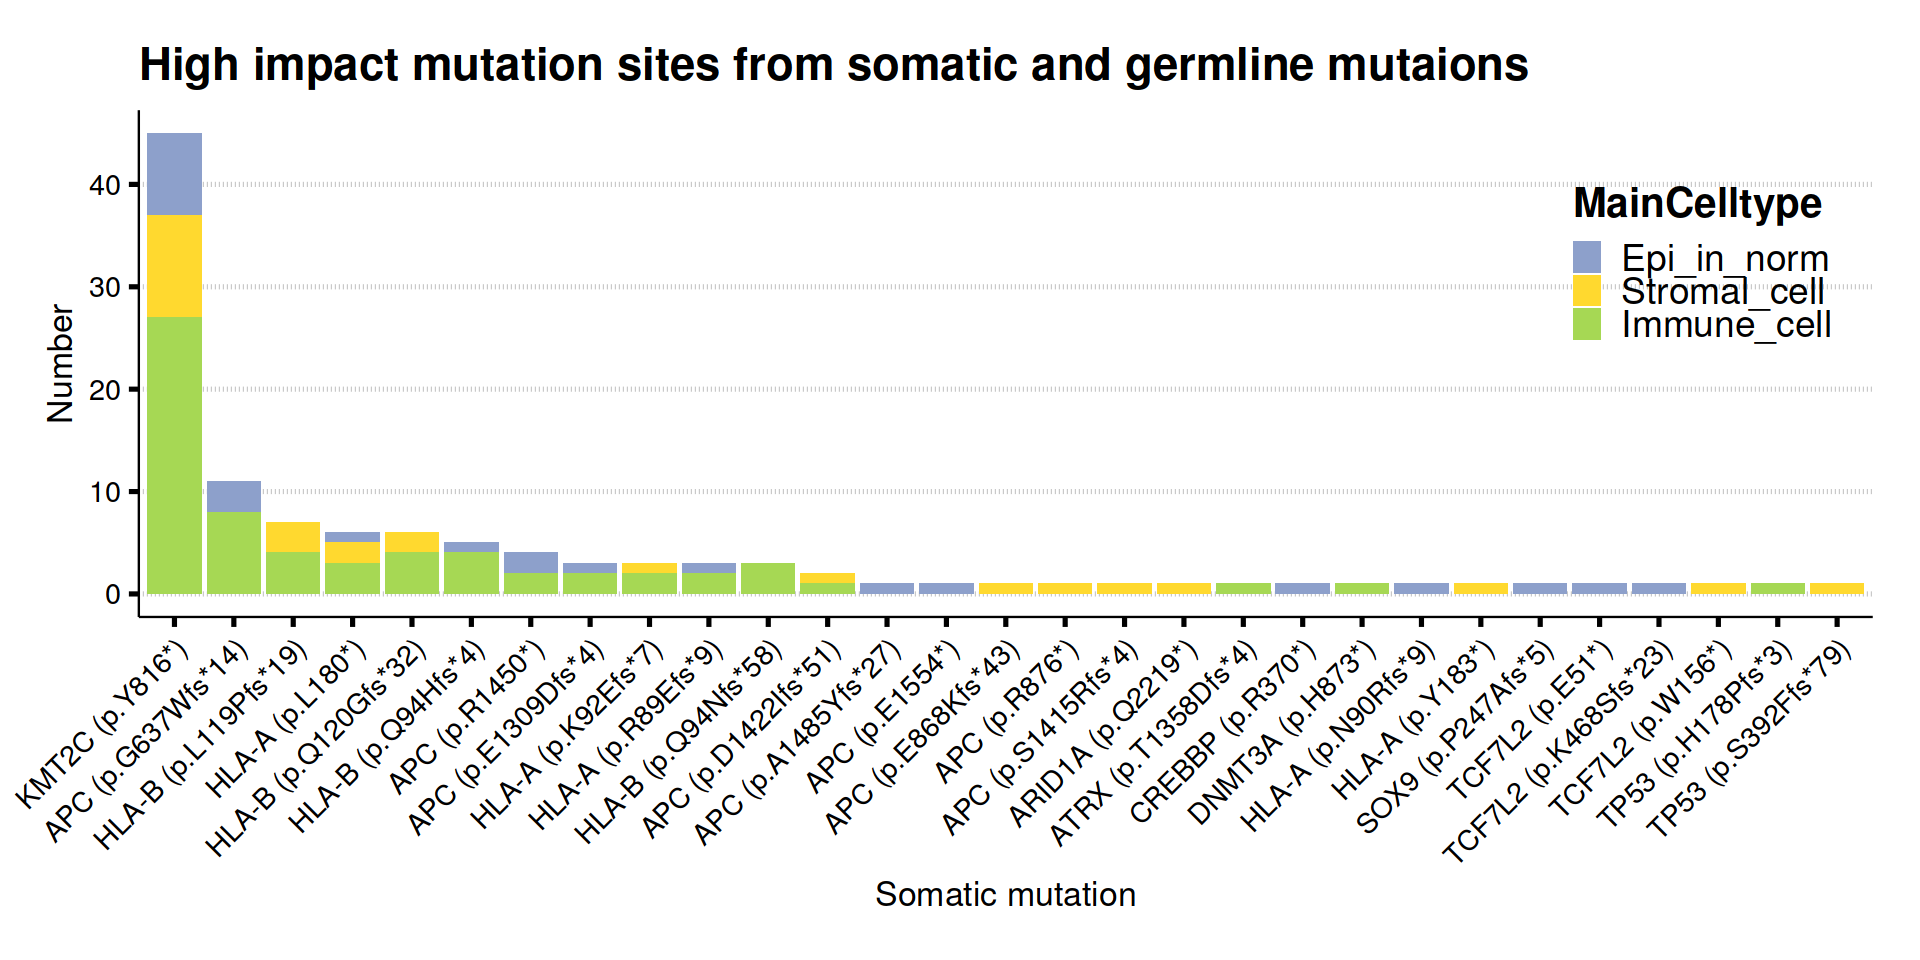

In [48]:
setfig( 16, 8 )

HIGH_HGVSp_terms_df <- HotspotGene_Somatic_Germline_Mutation_df %>% left_join( WES.SampleInfo %>% dplyr::select( Tumor_Sample_Barcode, MainCelltype ) %>% mutate( Tumor_Sample_Barcode = as.vector(Tumor_Sample_Barcode) ) ) %>% filter( HGVSp_Short_mod %in% HIGH_HGVSp_terms, MajorCelltype!="Cancer_cell" ) %>% mutate( label = paste0(str_replace_all(HGVSp_Short_mod, "__", " (" ),")") ) %>% mutate( HGVSp_Short_mod = factor(HGVSp_Short_mod, ordered = T, levels = HIGH_HGVSp_terms) ) %>% arrange( HGVSp_Short_mod )

HIGH_HGVSp_terms_df %>% ggplot( ., aes( HGVSp_Short_mod, fill = MainCelltype ) ) + geom_bar( stat = "count" ) + scale_fill_manual( values = MainCelltype_colors[ names(MainCelltype_colors)!="Cancer_cell" ] ) + labs( title = "High impact mutation sites from somatic and germline mutaions", x = "Somatic mutation", y = "Number" ) + scale_x_discrete( label = HIGH_HGVSp_terms_df$label %>% unique ) + theme_clean( base_size = 24 ) + theme( axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1), legend.background = element_blank(), plot.background = element_blank(), legend.position = c(.9,.7), plot.margin = unit(c(1,1,1,1),"cm") )

In [49]:
pdf( "./00.manuscript/05.KeyGenes_And_MultiModel/MutationSites_HighImpactMutation_Celltypes_Number_barplot.pdf", 16, 8, useDingbats = F )

setfig( 16, 8 )

HIGH_HGVSp_terms_df <- HotspotGene_Somatic_Germline_Mutation_df %>% left_join( WES.SampleInfo %>% dplyr::select( Tumor_Sample_Barcode, MainCelltype ) %>% mutate( Tumor_Sample_Barcode = as.vector(Tumor_Sample_Barcode) ) ) %>% filter( HGVSp_Short_mod %in% HIGH_HGVSp_terms, MajorCelltype!="Cancer_cell" ) %>% mutate( label = paste0(str_replace_all(HGVSp_Short_mod, "__", " (" ),")") ) %>% mutate( HGVSp_Short_mod = factor(HGVSp_Short_mod, ordered = T, levels = HIGH_HGVSp_terms) ) %>% arrange( HGVSp_Short_mod )

HIGH_HGVSp_terms_df %>% ggplot( ., aes( HGVSp_Short_mod, fill = MainCelltype ) ) + geom_bar( stat = "count" ) + scale_fill_manual( values = MainCelltype_colors[ names(MainCelltype_colors)!="Cancer_cell" ] ) + labs( title = "High impact mutation sites from somatic and germline mutaions", x = "Somatic mutation", y = "Number" ) + scale_x_discrete( label = HIGH_HGVSp_terms_df$label %>% unique ) + theme_clean( base_size = 24 ) + theme( axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1), legend.background = element_blank(), plot.background = element_blank(), legend.position = c(.9,.7), plot.margin = unit(c(1,1,1,1),"cm") )

dev.off()

Joining, by = "Tumor_Sample_Barcode"


png 
  2

### load data

In [133]:
TCGA_COAD_path <- "/home/zorro/lnk_datd/projects/NonEpiMutation/00.resources/TCGA_COAD/"

# TCGA_infiltration.TIMER <- read.csv( gzfile(paste0("/home/zorro/lnk_datd/references/DownstreamResources/TCGA_Resources/TCGA_PanCancer/Timer_ImmuneScore_infiltration_estimation_for_tcga.csv.gz")), header=T, row.names = 1 ) %>% dplyr::select( contains("_TIMER") )
# TCGA_infiltration.CIBERSORT <- read.csv( gzfile(paste0("/home/zorro/lnk_datd/references/DownstreamResources/TCGA_Resources/TCGA_PanCancer/Timer_ImmuneScore_infiltration_estimation_for_tcga.csv.gz")), header=T, row.names = 1 ) %>% dplyr::select( contains("_CIBERSORT") ) %>% dplyr::select( -contains("_CIBERSORT.ABS") )
TCGA_infiltration.XCELL <- read.csv( gzfile(paste0("/home/zorro/lnk_datd/references/DownstreamResources/TCGA_Resources/TCGA_PanCancer/Timer_ImmuneScore_infiltration_estimation_for_tcga.csv.gz")), header=T, row.names = 1 ) %>% dplyr::select( contains("_XCELL") )

COAD.Clinical <- read.delim2( paste0(TCGA_COAD_path,"TCGA_COAD_clinical_info.txt"), header=T, check.names = F ) %>% mutate( Row.names = sampleID ) %>% column_to_rownames( "Row.names" )
COAD.GeneMutations <- read.delim2( gzfile(paste0(TCGA_COAD_path,"TCGA_COAD_Mutations_mc3_gene_level.txt.gz")), header=T, check.names = F ) %>% drop_na( sample ) %>% column_to_rownames( "sample" )
COAD.SiteMutations <- read.delim2( gzfile(paste0(TCGA_COAD_path,"TCGA_COAD_Mutations_mc3_site_level.txt.gz")), header=T, check.names = F ) %>% mutate( Row.names = sample )
COAD.TumorPurity <- read.delim2( paste0(TCGA_COAD_path,"TCGA_PanCancer_tumor_purity_info.txt"), header=T, check.names = F ) %>% mutate( Row.names = array ) %>% column_to_rownames( "Row.names" )
COAD.log2expr <- read.delim2( gzfile(paste0(TCGA_COAD_path,"TCGA_COAD_RNA_log2norm_HiSeqV2.txt.gz")), header=T, check.names = F ) %>% drop_na( sample ) %>% column_to_rownames( "sample" )

COAD.samples <- list( rownames(COAD.Clinical), colnames(COAD.GeneMutations), COAD.SiteMutations$sample %>% unique, rownames(COAD.TumorPurity), colnames(COAD.log2expr), rownames(TCGA_infiltration.XCELL) ) %>% Reduce( intersect, . )
COAD.Clinical %<>% .[ COAD.samples, ]
COAD.GeneMutations %<>% .[ , COAD.samples ]
COAD.SiteMutations %<>% filter( Row.names %in% COAD.samples )
COAD.TumorPurity %<>% .[ COAD.samples, ]
COAD.log2expr %<>% .[ , COAD.samples ]

COAD.Infiltration_XCELL <- TCGA_infiltration.XCELL %>% .[ COAD.samples, ]

save( COAD.samples, COAD.Clinical, COAD.GeneMutations, COAD.SiteMutations, COAD.TumorPurity, COAD.log2expr, COAD.Infiltration_XCELL, file = paste0( TCGA_COAD_path, "TCGA_COAD_integrated.rdata" ) )

In [84]:
load( "/home/zorro/lnk_datd/projects/NonEpiMutation/00.resources/TCGA_COAD/TCGA_COAD_integrated.rdata" )

### Hotspot, Oncogenes and TSGs - Cell type fraction - Tumor purity

In [85]:
COAD.Mutation_With_Purity <- COAD.SiteMutations %>% filter( effect!="Silent" ) %>% group_by( sample ) %>% summarise( count = n(), Hotspot = length(intersect(unique(gene), Hotspot_Genes)), OG = length(intersect(unique(gene), Hotspot_Genes_In_OG )), TSG = length(intersect(unique(gene), Hotspot_Genes_In_TSG )) ) %>% as.data.frame %>% left_join( COAD.TumorPurity %>% dplyr::select(c("array","purity","ploidy","Cancer DNA fraction")) %>% dplyr::rename( sample = "array" ) ) %>% mutate( purity=as.numeric(purity), ploidy=as.numeric(ploidy), `Cancer DNA fraction`=as.numeric(`Cancer DNA fraction`) ) %>% arrange( purity ) %>% mutate( `log10 of count` = log10(count) )

Joining, by = "sample"


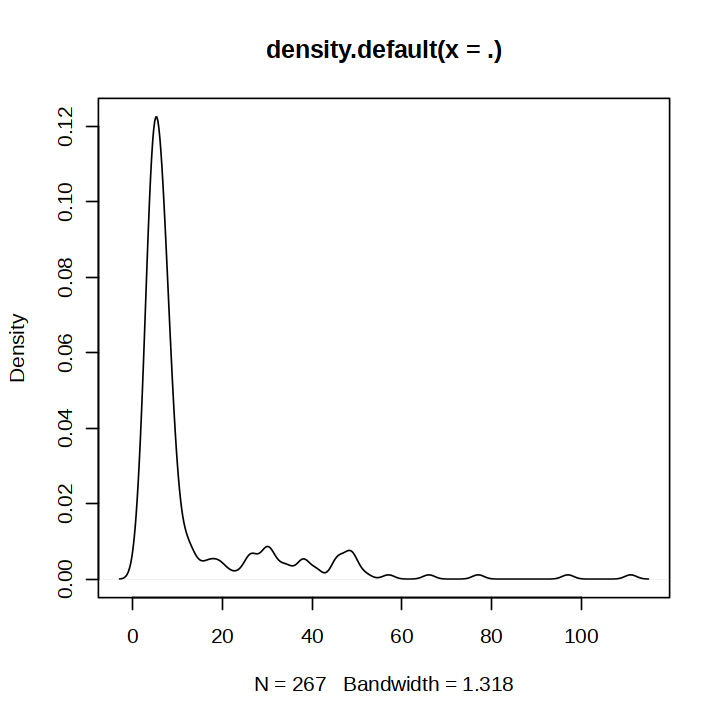

In [86]:
setfig( 6, 6 )
COAD.Mutation_With_Purity$Hotspot %>% density %>% plot

In [91]:
COAD.SiteMutations_HotspotSites <- COAD.SiteMutations %>% filter( effect!="Silent" ) %>% mutate( HGVSp_Short_mod = paste0(gene,"__",Amino_Acid_Change) ) %>% filter( HGVSp_Short_mod %in% Hotspot_Genes_df$HGVSp_Short_mod )

COAD.Mutation_With_Purity_HotspotSites <- COAD.SiteMutations_HotspotSites %>% group_by( sample ) %>% summarise( Hotspot_Site_Count = n() ) %>% as.data.frame %>% left_join( COAD.TumorPurity %>% dplyr::select(c("array","purity","ploidy","Cancer DNA fraction")) %>% dplyr::rename( sample = "array" ) ) %>% mutate( purity=as.numeric(purity), ploidy=as.numeric(ploidy), `Cancer DNA fraction`=as.numeric(`Cancer DNA fraction`) ) %>% filter( Hotspot_Site_Count<=6 )

Joining, by = "sample"


In [92]:
COAD.Mutation_With_Purity_HotspotSites$Hotspot_Site_Count %>% table

.
 1  2  3  4  5  6 
67 66 76 19 15  3 

Warning message:
"Using `bins = 30` by default. Pick better value with the argument `bins`."


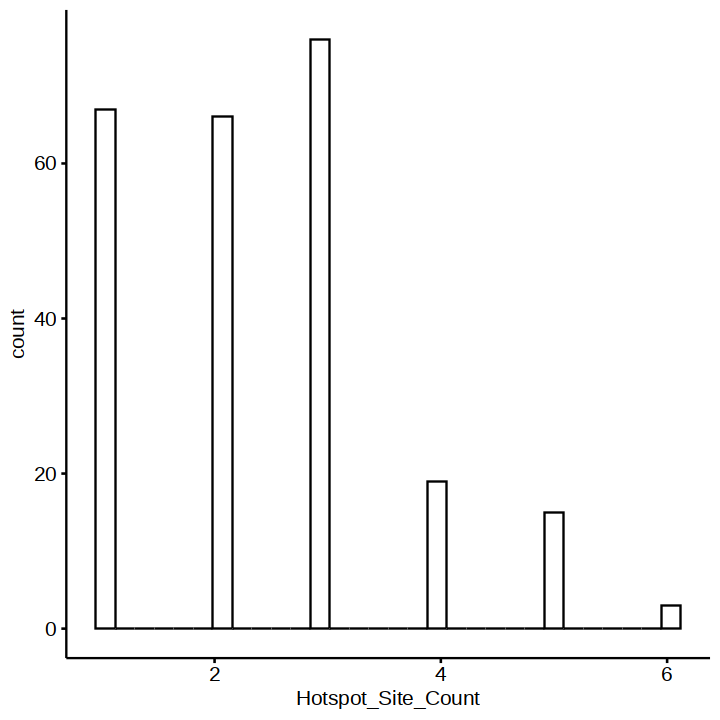

In [88]:
setfig( 6, 6 )
gghistogram( COAD.Mutation_With_Purity_HotspotSites, "Hotspot_Site_Count" )

Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 1 rows containing missing values (geom_point)."
Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 1 rows containing missing values (geom_point)."


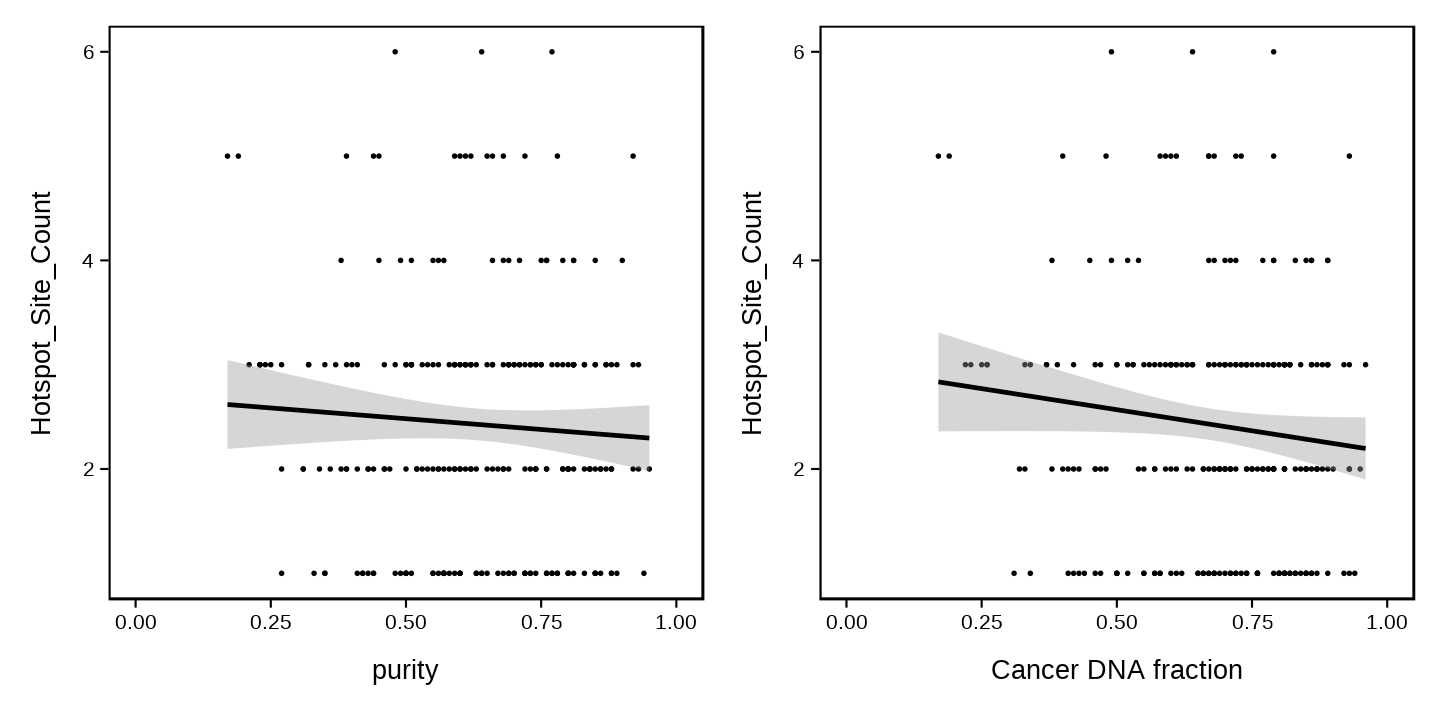

In [255]:
setfig( 12, 6 )

COAD.Mutation_With_Purity_HotspotSites %>% 
    ggplot( ., aes( purity, Hotspot_Site_Count ) ) + geom_point( size = .5 ) + scale_x_continuous( limits = c(0,1) ) + 
        geom_smooth( method = "lm", se=TRUE, color="black", formula = y ~ x) +
        theme_linedraw( base_size = 20 ) + theme( panel.grid.major = element_blank(), panel.grid.minor = element_blank() ) |
COAD.Mutation_With_Purity_HotspotSites %>% 
    ggplot( ., aes( `Cancer DNA fraction`, Hotspot_Site_Count ) ) + geom_point( size = .5 ) + scale_x_continuous( limits = c(0,1) ) + 
        geom_smooth( method = "lm", se=TRUE, color="black", formula = y ~ x) +
        theme_linedraw( base_size = 20 ) + theme( panel.grid.major = element_blank(), panel.grid.minor = element_blank() )

# COAD.Mutation_With_Purity %>% 
#     ggplot( ., aes( purity, log1p(Hotspot) ) ) + geom_point( size = .5 ) + scale_x_continuous( limits = c(0,1) ) + 
#         geom_smooth( method = "lm", se=TRUE, color="black", formula = y ~ x) +
#         theme_linedraw( base_size = 20 ) + theme( panel.grid.major = element_blank(), panel.grid.minor = element_blank() ) |
# COAD.Mutation_With_Purity %>% 
#     ggplot( ., aes( `Cancer DNA fraction`, log1p(Hotspot) ) ) + geom_point( size = .5 ) + scale_x_continuous( limits = c(0,1) ) + 
#         geom_smooth( method = "lm", se=TRUE, color="black", formula = y ~ x) +
#         theme_linedraw( base_size = 20 ) + theme( panel.grid.major = element_blank(), panel.grid.minor = element_blank() )

# COAD.Mutation_With_Purity %>% filter( Hotspot<=20 ) %>%
#     ggplot( ., aes( purity, Hotspot ) ) + geom_point( size = .5 ) + scale_x_continuous( limits = c(0,1) ) + 
#         geom_smooth( method = "lm", se=TRUE, color="black", formula = y ~ x) +
#         theme_linedraw( base_size = 20 ) + theme( panel.grid.major = element_blank(), panel.grid.minor = element_blank() ) |
# COAD.Mutation_With_Purity %>% filter( Hotspot<=20 ) %>%
#     ggplot( ., aes( `Cancer DNA fraction`, Hotspot ) ) + geom_point( size = .5 ) + scale_x_continuous( limits = c(0,1) ) + 
#         geom_smooth( method = "lm", se=TRUE, color="black", formula = y ~ x) +
#         theme_linedraw( base_size = 20 ) + theme( panel.grid.major = element_blank(), panel.grid.minor = element_blank() )


In [258]:
COAD.HotspotMutation_With_VAF_Purity <- COAD.SiteMutations %>% filter( effect!="Silent", gene %in% Hotspot_Genes ) %>% mutate( DNA_VAF = as.numeric(DNA_VAF) ) %>% group_by( sample ) %>% summarise( gene_num = n(), VAF_mean = mean( DNA_VAF ), VAF_sd = sd(DNA_VAF) ) %>% as.data.frame %>% left_join( COAD.Mutation_With_Purity ) %>% arrange( purity ) %>% mutate( `log10 of count` = log10(count) ) %>% left_join( COAD.Infiltration_XCELL %>% dplyr::select( c('immune.score_XCELL','stroma.score_XCELL','microenvironment.score_XCELL') ) %>% dplyr::rename_with(., function(X) splitName(X,"_",1) ) %>% rownames_to_column( "sample" ) ) %>% arrange( microenvironment.score )

COAD.HotspotMutation_With_VAF_Purity_HotspotSites <- COAD.SiteMutations_HotspotSites %>% mutate( DNA_VAF = as.numeric(DNA_VAF) ) %>% group_by( sample ) %>% summarise( gene_num = n(), VAF_mean = mean( DNA_VAF ), VAF_sd = sd(DNA_VAF) ) %>% as.data.frame %>% left_join( COAD.Mutation_With_Purity_HotspotSites ) %>% arrange( purity ) %>% left_join( COAD.Infiltration_XCELL %>% dplyr::select( c('immune.score_XCELL','stroma.score_XCELL','microenvironment.score_XCELL') ) %>% dplyr::rename_with(., function(X) splitName(X,"_",1) ) %>% rownames_to_column( "sample" ) ) %>% arrange( microenvironment.score )

Joining, by = "sample"
Joining, by = "sample"
Joining, by = "sample"
Joining, by = "sample"


Warning message:
"Removed 2 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 2 rows containing non-finite values (stat_cor)."
Warning message:
"Removed 2 rows containing non-finite values (stat_regline_equation)."
Warning message:
"Removed 2 rows containing missing values (geom_point)."
Warning message:
"Removed 2 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 2 rows containing non-finite values (stat_cor)."
Warning message:
"Removed 2 rows containing non-finite values (stat_regline_equation)."
Warning message:
"Removed 2 rows containing missing values (geom_point)."
Warning message:
"Removed 2 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 2 rows containing non-finite values (stat_cor)."
Warning message:
"Removed 2 rows containing non-finite values (stat_regline_equation)."
Warning message:
"Removed 2 rows containing missing values (geom_point)."
Warning message:
"Removed 2 rows containing non-finite 

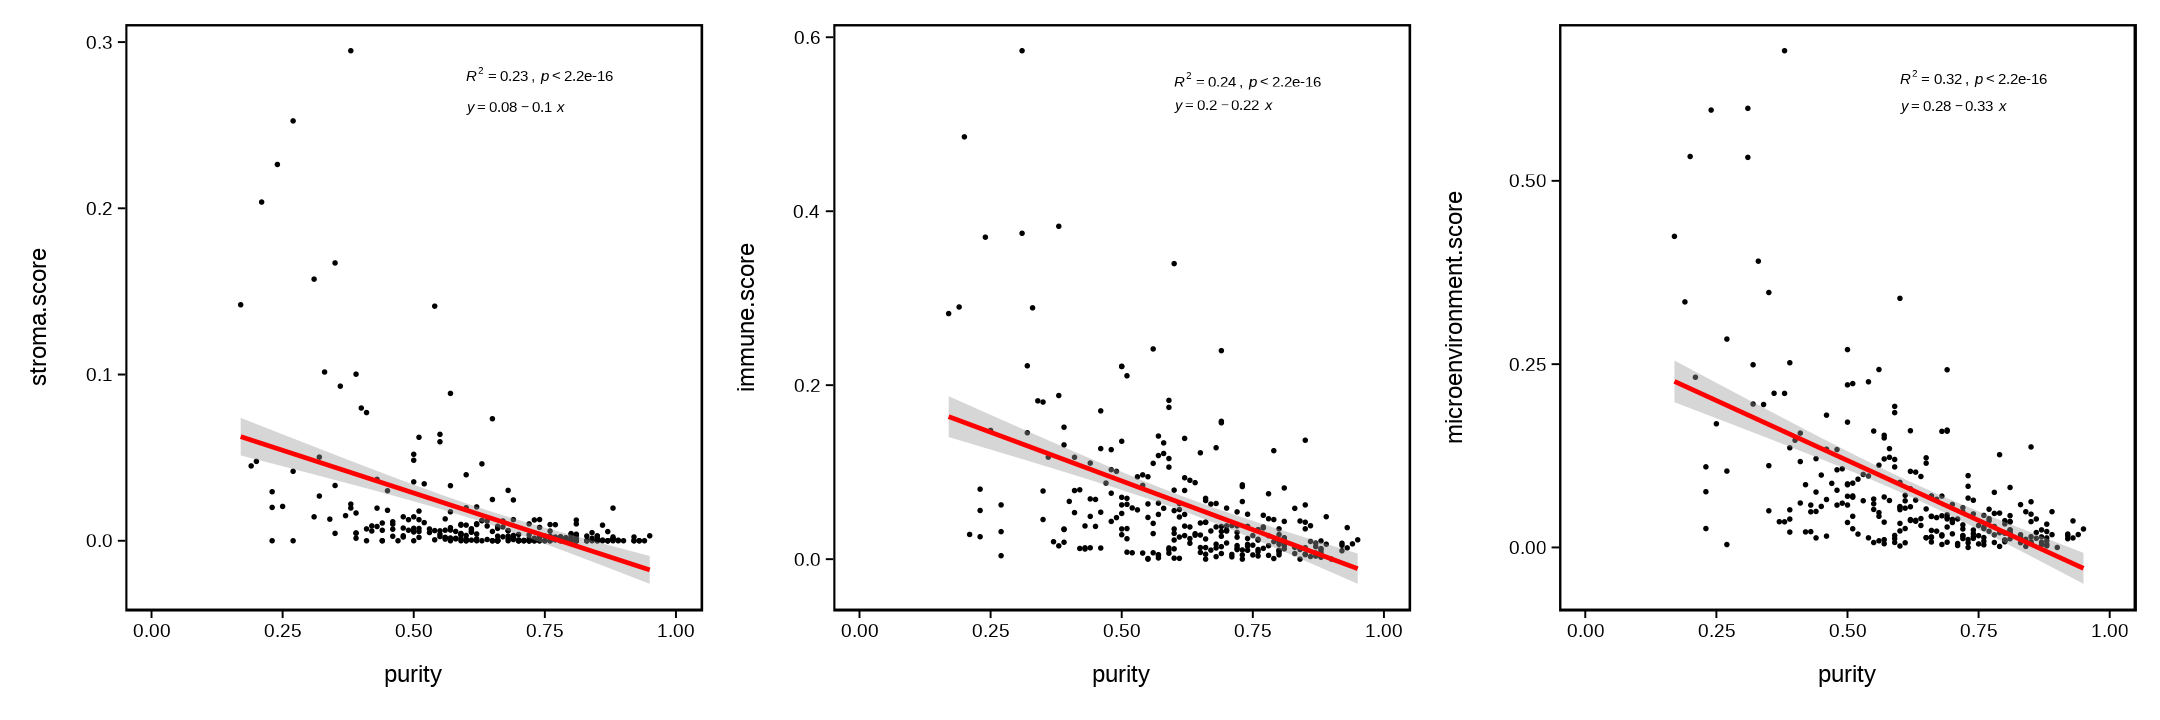

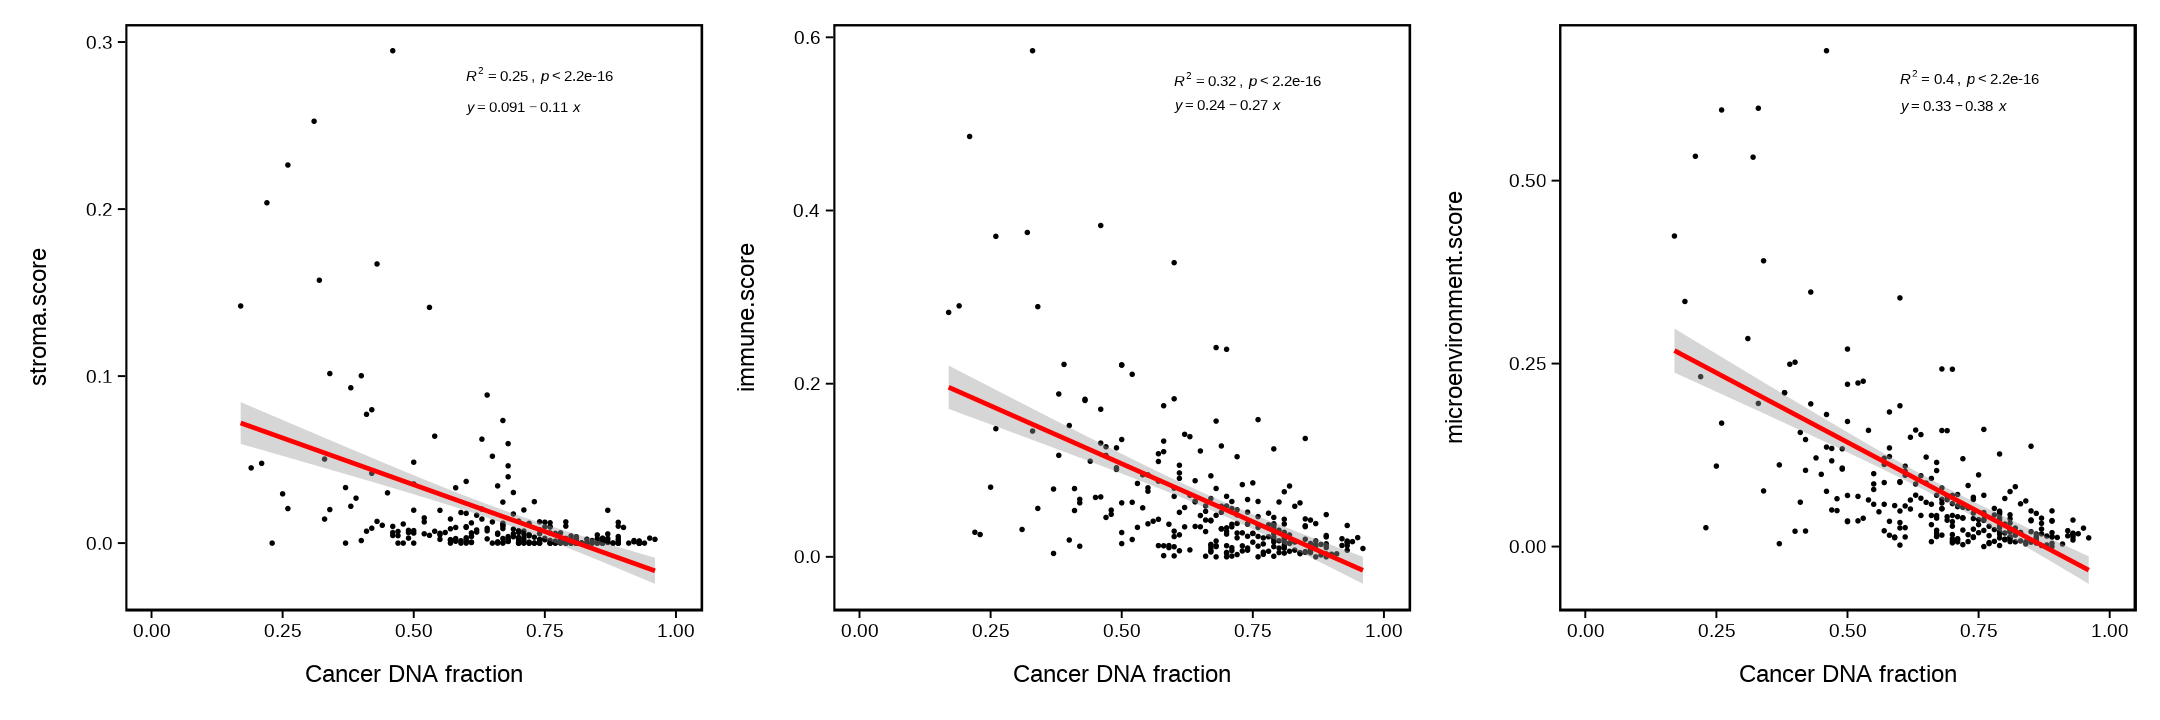

In [165]:
setfig( 18, 6 )

COAD.HotspotMutation_With_VAF_Purity %>% 
    ggplot( ., aes( purity, stroma.score ) ) + geom_point( size = .5 ) + scale_x_continuous( limits = c(0,1) ) + 
        geom_smooth( method = "lm", se=TRUE, color="red", formula = y ~ x) +
        stat_cor( label.x = .6, label.y = .28, aes(label = paste(..rr.label.., ..p.label.., sep = "~`,`~"))) + stat_regline_equation( label.x = .6, label.y = .26) +
        theme_linedraw( base_size = 18 ) + theme( panel.grid.major = element_blank(), panel.grid.minor = element_blank() ) |
COAD.HotspotMutation_With_VAF_Purity %>% 
    ggplot( ., aes( purity, immune.score ) ) + geom_point( size = .5 ) + scale_x_continuous( limits = c(0,1) ) + 
        geom_smooth( method = "lm", se=TRUE, color="red", formula = y ~ x) +
        stat_cor( label.x = .6, label.y = .55, aes(label = paste(..rr.label.., ..p.label.., sep = "~`,`~"))) + stat_regline_equation( label.x = .6, label.y = .52 ) +
        theme_linedraw( base_size = 18 ) + theme( panel.grid.major = element_blank(), panel.grid.minor = element_blank() ) |
COAD.HotspotMutation_With_VAF_Purity %>% 
    ggplot( ., aes( purity, microenvironment.score ) ) + geom_point( size = .5 ) + scale_x_continuous( limits = c(0,1) ) + 
        geom_smooth( method = "lm", se=TRUE, color="red", formula = y ~ x) +
        stat_cor( label.x = .6, label.y = .64, aes(label = paste(..rr.label.., ..p.label.., sep = "~`,`~"))) + stat_regline_equation( label.x = .6, label.y = .6 ) +
        theme_linedraw( base_size = 18 ) + theme( panel.grid.major = element_blank(), panel.grid.minor = element_blank() )

COAD.HotspotMutation_With_VAF_Purity %>% 
    ggplot( ., aes( `Cancer DNA fraction`, stroma.score ) ) + geom_point( size = .5 ) + scale_x_continuous( limits = c(0,1) ) + 
        geom_smooth( method = "lm", se=TRUE, color="red", formula = y ~ x) +
        stat_cor( label.x = .6, label.y = .28, aes(label = paste(..rr.label.., ..p.label.., sep = "~`,`~"))) + stat_regline_equation( label.x = .6, label.y = .26) +
        theme_linedraw( base_size = 18 ) + theme( panel.grid.major = element_blank(), panel.grid.minor = element_blank() ) |
COAD.HotspotMutation_With_VAF_Purity %>% 
    ggplot( ., aes( `Cancer DNA fraction`, immune.score ) ) + geom_point( size = .5 ) + scale_x_continuous( limits = c(0,1) ) + 
        geom_smooth( method = "lm", se=TRUE, color="red", formula = y ~ x) +
        stat_cor( label.x = .6, label.y = .55, aes(label = paste(..rr.label.., ..p.label.., sep = "~`,`~"))) + stat_regline_equation( label.x = .6, label.y = .52 ) +
        theme_linedraw( base_size = 18 ) + theme( panel.grid.major = element_blank(), panel.grid.minor = element_blank() ) |
COAD.HotspotMutation_With_VAF_Purity %>% 
    ggplot( ., aes( `Cancer DNA fraction`, microenvironment.score ) ) + geom_point( size = .5 ) + scale_x_continuous( limits = c(0,1) ) + 
        geom_smooth( method = "lm", se=TRUE, color="red", formula = y ~ x) +
        stat_cor( label.x = .6, label.y = .64, aes(label = paste(..rr.label.., ..p.label.., sep = "~`,`~"))) + stat_regline_equation( label.x = .6, label.y = .6 ) +
        theme_linedraw( base_size = 18 ) + theme( panel.grid.major = element_blank(), panel.grid.minor = element_blank() )

Warning message:
"Removed 2 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 2 rows containing missing values (geom_point)."
Warning message:
"Removed 2 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 2 rows containing missing values (geom_point)."
Warning message:
"Removed 4 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 4 rows containing missing values (geom_point)."
Warning message:
"Removed 4 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 4 rows containing missing values (geom_point)."


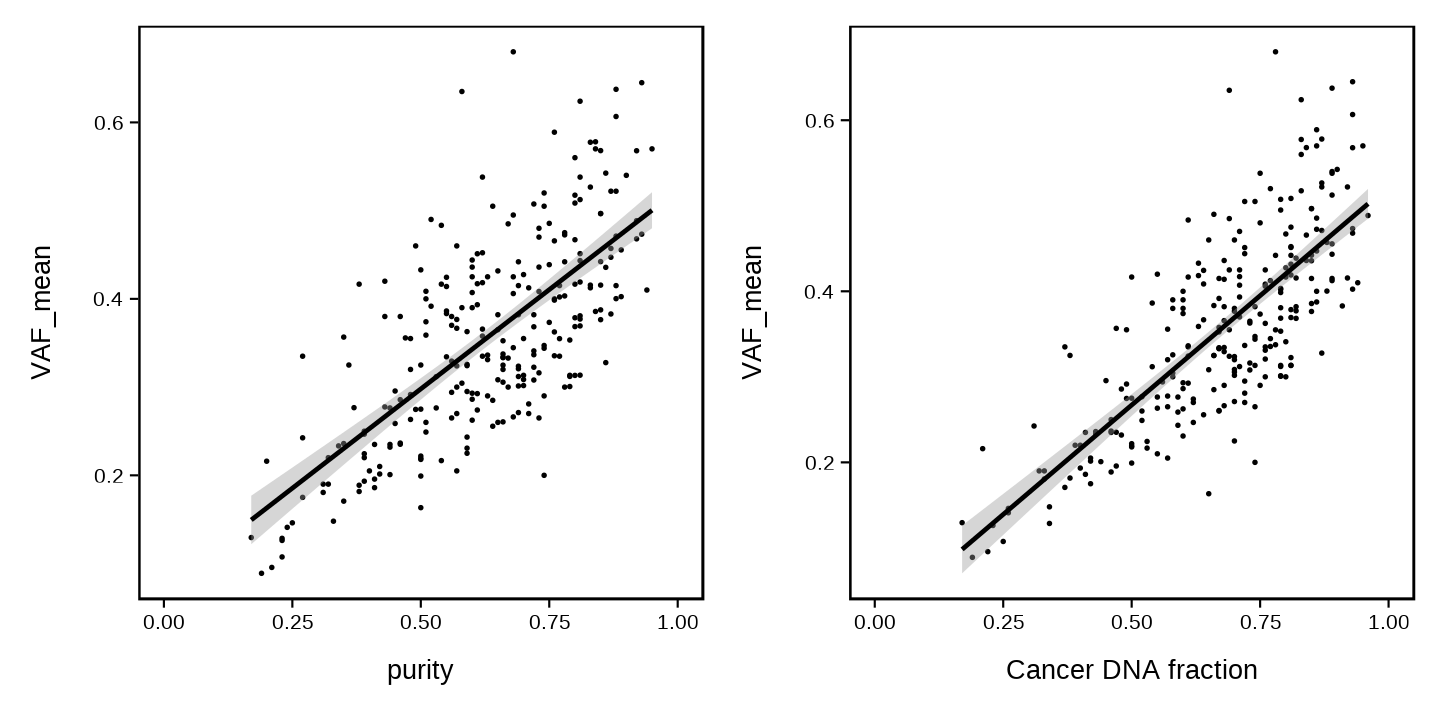

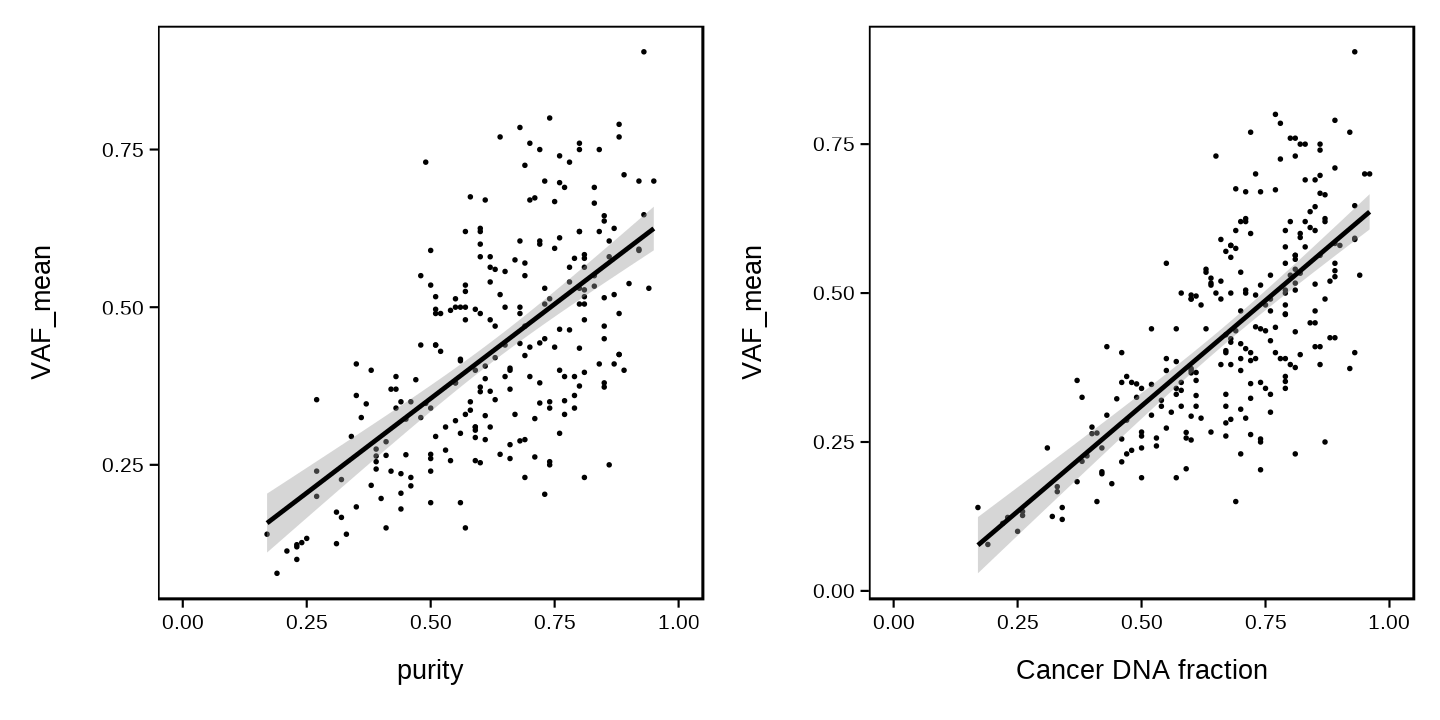

In [259]:
setfig( 12, 6 )

COAD.HotspotMutation_With_VAF_Purity %>% 
    ggplot( ., aes( purity, VAF_mean ) ) + geom_point( size = .5 ) + scale_x_continuous( limits = c(0,1) ) + 
        geom_smooth( method = "lm", se=TRUE, color="black", formula = y ~ x) +
        theme_linedraw( base_size = 20 ) + theme( panel.grid.major = element_blank(), panel.grid.minor = element_blank() ) |
COAD.HotspotMutation_With_VAF_Purity %>% 
    ggplot( ., aes( `Cancer DNA fraction`, VAF_mean ) ) + geom_point( size = .5 ) + scale_x_continuous( limits = c(0,1) ) + 
        geom_smooth( method = "lm", se=TRUE, color="black", formula = y ~ x) +
        theme_linedraw( base_size = 20 ) + theme( panel.grid.major = element_blank(), panel.grid.minor = element_blank() )

COAD.HotspotMutation_With_VAF_Purity_HotspotSites %>% 
    ggplot( ., aes( purity, VAF_mean ) ) + geom_point( size = .5 ) + scale_x_continuous( limits = c(0,1) ) + 
        geom_smooth( method = "lm", se=TRUE, color="black", formula = y ~ x) +
        theme_linedraw( base_size = 20 ) + theme( panel.grid.major = element_blank(), panel.grid.minor = element_blank() ) |
COAD.HotspotMutation_With_VAF_Purity_HotspotSites %>% 
    ggplot( ., aes( `Cancer DNA fraction`, VAF_mean ) ) + geom_point( size = .5 ) + scale_x_continuous( limits = c(0,1) ) + 
        geom_smooth( method = "lm", se=TRUE, color="black", formula = y ~ x) +
        theme_linedraw( base_size = 20 ) + theme( panel.grid.major = element_blank(), panel.grid.minor = element_blank() )

Warning message:
"Removed 3 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 3 rows containing non-finite values (stat_cor)."
Warning message:
"Removed 3 rows containing non-finite values (stat_regline_equation)."
Warning message:
"Removed 3 rows containing missing values (geom_point)."
Warning message:
"Removed 3 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 3 rows containing non-finite values (stat_cor)."
Warning message:
"Removed 3 rows containing non-finite values (stat_regline_equation)."
Warning message:
"Removed 3 rows containing missing values (geom_point)."
Warning message:
"Removed 3 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 3 rows containing non-finite values (stat_cor)."
Warning message:
"Removed 3 rows containing non-finite values (stat_regline_equation)."
Warning message:
"Removed 3 rows containing missing values (geom_point)."


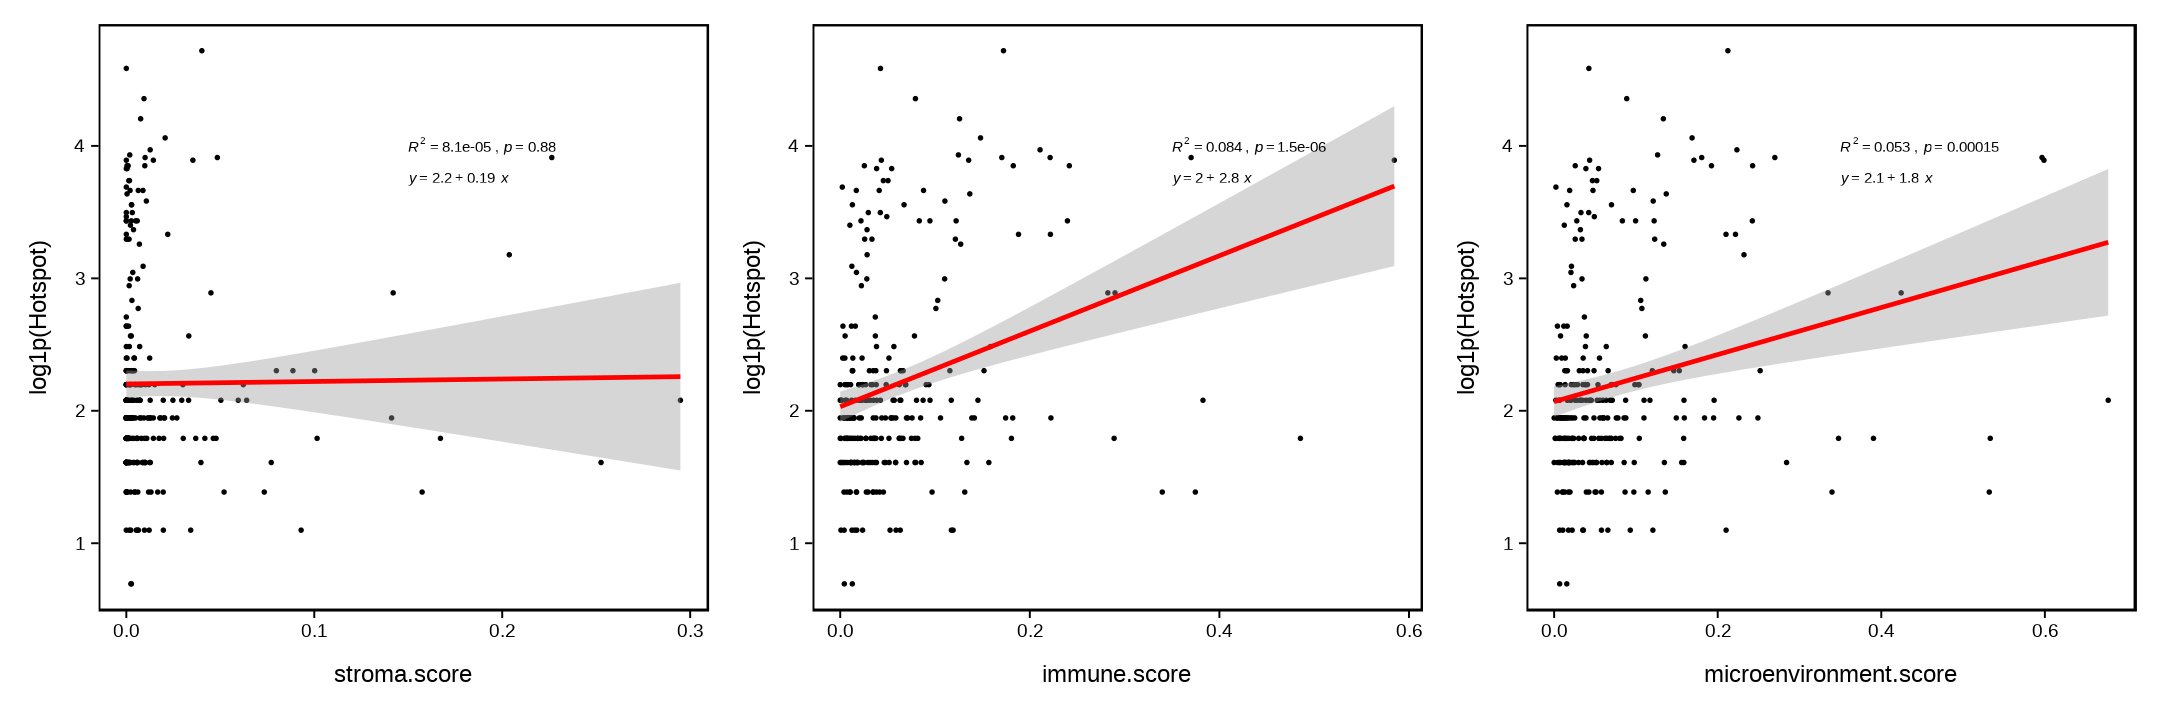

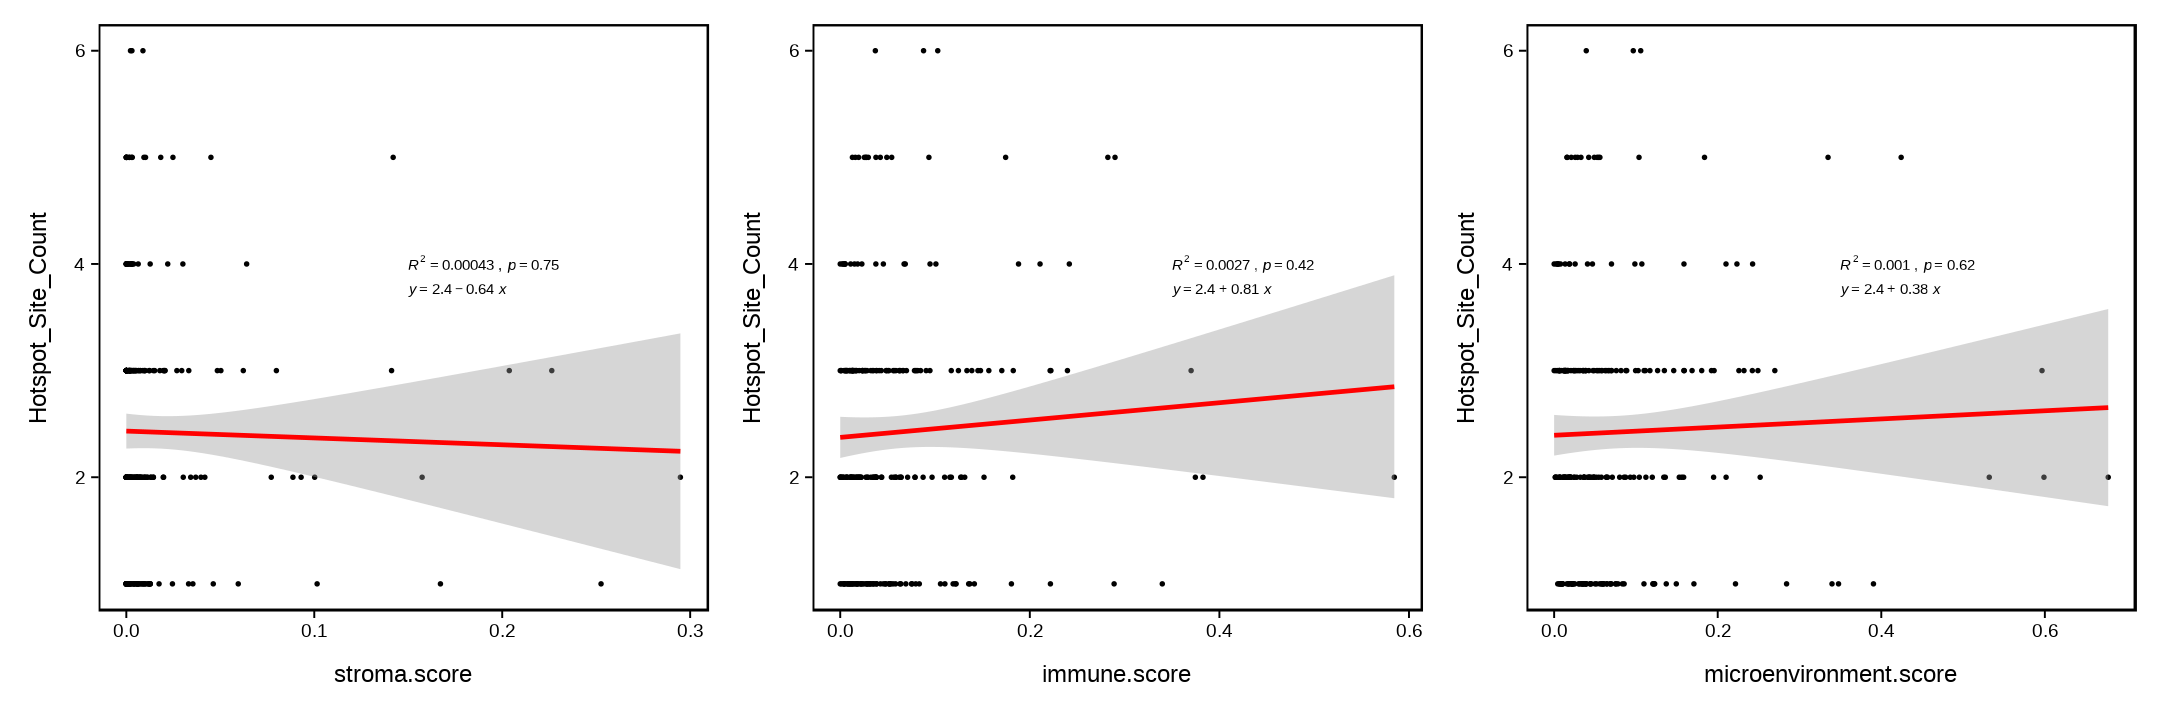

In [260]:
setfig( 18, 6 )

COAD.HotspotMutation_With_VAF_Purity %>% 
    ggplot( ., aes( stroma.score, log1p(Hotspot) ) ) + geom_point( size = .5 ) +
        geom_smooth( method = "lm", se=TRUE, color="red", formula = y ~ x) +
        stat_cor( label.x = .15, label.y = 4, aes(label = paste(..rr.label.., ..p.label.., sep = "~`,`~"))) + stat_regline_equation( label.x = .15, label.y = 3.75 ) +
        theme_linedraw( base_size = 18 ) + theme( panel.grid.major = element_blank(), panel.grid.minor = element_blank() ) |
COAD.HotspotMutation_With_VAF_Purity %>% 
    ggplot( ., aes( immune.score, log1p(Hotspot) ) ) + geom_point( size = .5 ) +
        geom_smooth( method = "lm", se=TRUE, color="red", formula = y ~ x) +
        stat_cor( label.x = .35, label.y = 4, aes(label = paste(..rr.label.., ..p.label.., sep = "~`,`~"))) + stat_regline_equation( label.x = .35, label.y = 3.75 ) +
        theme_linedraw( base_size = 18 ) + theme( panel.grid.major = element_blank(), panel.grid.minor = element_blank() ) |
COAD.HotspotMutation_With_VAF_Purity %>% #filter( count<=20 ) %>% 
    ggplot( ., aes( microenvironment.score, log1p(Hotspot) ) ) + geom_point( size = .5 ) +
        geom_smooth( method = "lm", se=TRUE, color="red", formula = y ~ x) +
        stat_cor( label.x = .35, label.y = 4, aes(label = paste(..rr.label.., ..p.label.., sep = "~`,`~"))) + stat_regline_equation( label.x = .35, label.y = 3.75 ) +
        theme_linedraw( base_size = 18 ) + theme( panel.grid.major = element_blank(), panel.grid.minor = element_blank() )

COAD.HotspotMutation_With_VAF_Purity_HotspotSites %>% 
    ggplot( ., aes( stroma.score, Hotspot_Site_Count ) ) + geom_point( size = .5 ) +
        geom_smooth( method = "lm", se=TRUE, color="red", formula = y ~ x) +
        stat_cor( label.x = .15, label.y = 4, aes(label = paste(..rr.label.., ..p.label.., sep = "~`,`~"))) + stat_regline_equation( label.x = .15, label.y = 3.75 ) +
        theme_linedraw( base_size = 18 ) + theme( panel.grid.major = element_blank(), panel.grid.minor = element_blank() ) |
COAD.HotspotMutation_With_VAF_Purity_HotspotSites %>% 
    ggplot( ., aes( immune.score, Hotspot_Site_Count ) ) + geom_point( size = .5 ) +
        geom_smooth( method = "lm", se=TRUE, color="red", formula = y ~ x) +
        stat_cor( label.x = .35, label.y = 4, aes(label = paste(..rr.label.., ..p.label.., sep = "~`,`~"))) + stat_regline_equation( label.x = .35, label.y = 3.75 ) +
        theme_linedraw( base_size = 18 ) + theme( panel.grid.major = element_blank(), panel.grid.minor = element_blank() ) |
COAD.HotspotMutation_With_VAF_Purity_HotspotSites %>% #filter( count<=20 ) %>% 
    ggplot( ., aes( microenvironment.score, Hotspot_Site_Count ) ) + geom_point( size = .5 ) +
        geom_smooth( method = "lm", se=TRUE, color="red", formula = y ~ x) +
        stat_cor( label.x = .35, label.y = 4, aes(label = paste(..rr.label.., ..p.label.., sep = "~`,`~"))) + stat_regline_equation( label.x = .35, label.y = 3.75 ) +
        theme_linedraw( base_size = 18 ) + theme( panel.grid.major = element_blank(), panel.grid.minor = element_blank() )

In [212]:
# COAD.HotspotMutation_With_VAF_Purity %>% mutate( `log10 (VAF * Count)`=log10(VAF_mean*count) ) %>%
#     ggplot( ., aes( stroma.score, `log10 (VAF * Count)` ) ) + geom_point( size = .5 ) +
#         geom_smooth( method = "lm", se=TRUE, color="red", formula = y ~ x) +
#         stat_cor( label.x = .15, label.y = 2.5, aes(label = paste(..rr.label.., ..p.label.., sep = "~`,`~"))) + stat_regline_equation( label.x = .15, label.y = 2.35 ) +
#         theme_linedraw( base_size = 18 ) + theme( panel.grid.major = element_blank(), panel.grid.minor = element_blank() ) |

# COAD.HotspotMutation_With_VAF_Purity %>% mutate( `log10 (VAF * Count)`=log10(VAF_mean*count) ) %>%
#     ggplot( ., aes( immune.score, `log10 (VAF * Count)` ) ) + geom_point( size = .5 ) +
#         geom_smooth( method = "lm", se=TRUE, color="red", formula = y ~ x) +
#         stat_cor( label.x = .15, label.y = 2.5, aes(label = paste(..rr.label.., ..p.label.., sep = "~`,`~"))) + stat_regline_equation( label.x = .15, label.y = 2.35 ) +
#         theme_linedraw( base_size = 18 ) + theme( panel.grid.major = element_blank(), panel.grid.minor = element_blank() ) |

# COAD.HotspotMutation_With_VAF_Purity %>% mutate( `log10 (VAF * Count)`=log10(VAF_mean*count) ) %>%
#     ggplot( ., aes( microenvironment.score, `log10 (VAF * Count)`) ) + geom_point( size = .5 ) +
#         geom_smooth( method = "lm", se=TRUE, color="red", formula = y ~ x) +
#         stat_cor( label.x = .15, label.y = 2.5, aes(label = paste(..rr.label.., ..p.label.., sep = "~`,`~"))) + stat_regline_equation( label.x = .15, label.y = 2.35 ) +
#         theme_linedraw( base_size = 18 ) + theme( panel.grid.major = element_blank(), panel.grid.minor = element_blank() )

Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 1 rows containing non-finite values (stat_cor)."
Warning message:
"Removed 1 rows containing non-finite values (stat_regline_equation)."
Warning message:
"Removed 1 rows containing missing values (geom_point)."
Warning message:
"Removed 1 rows containing missing values (geom_point)."


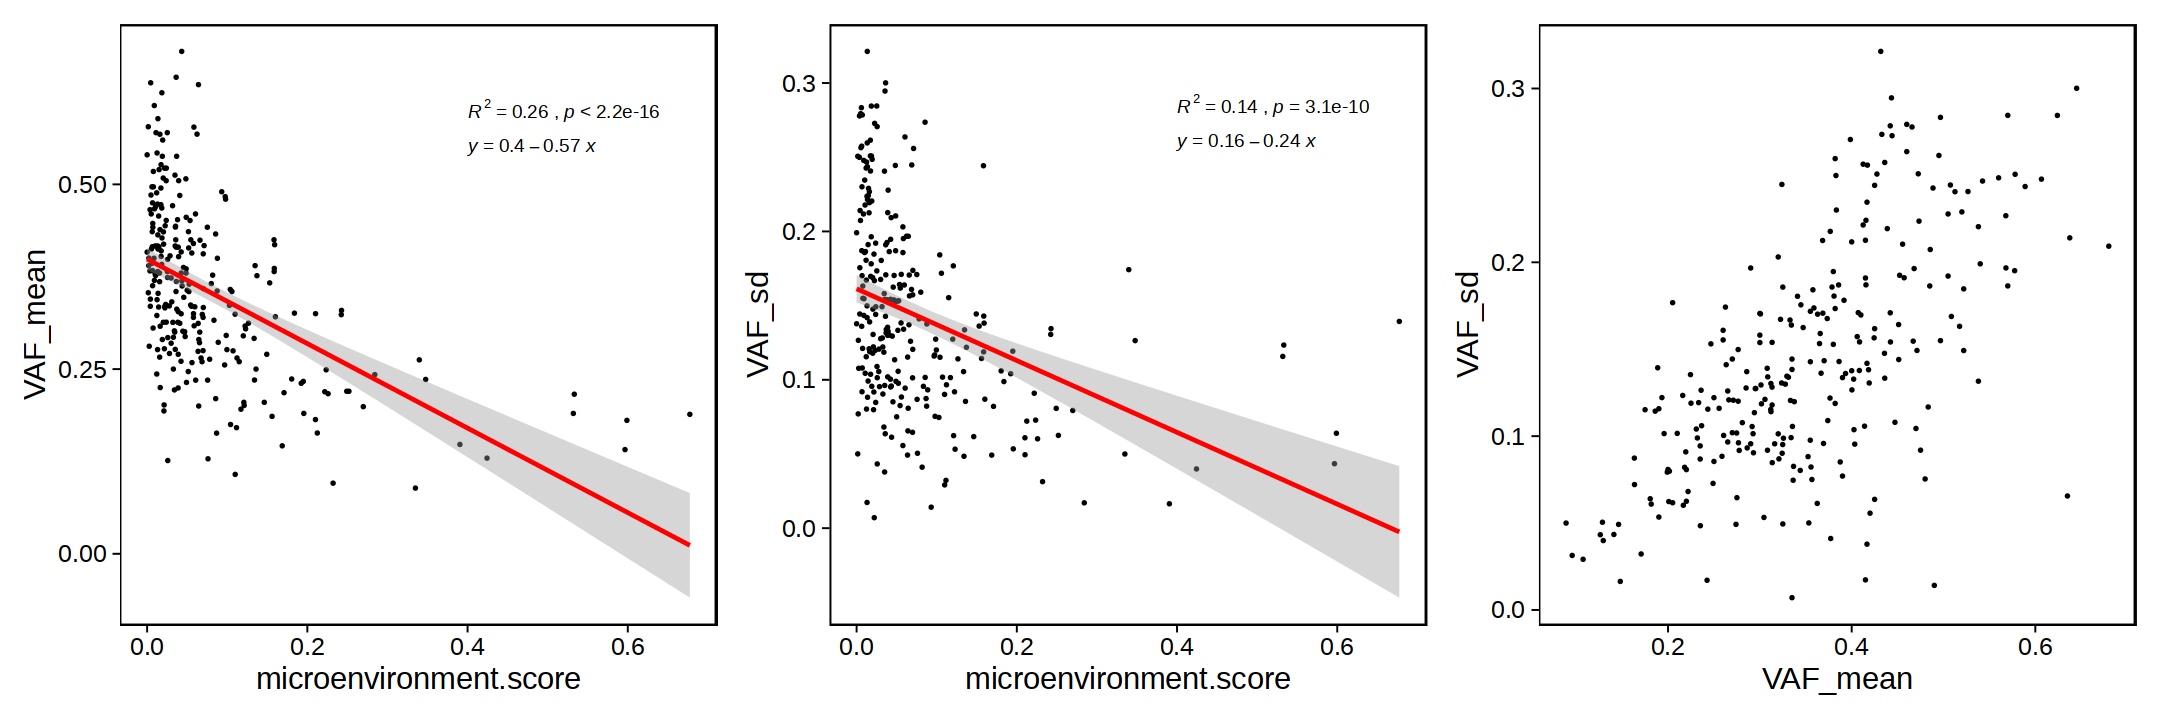

In [213]:
setfig( 18, 6 )

COAD.HotspotMutation_With_VAF_Purity %>% 
    ggplot( ., aes( microenvironment.score, VAF_mean ) ) + geom_point( size = .5 ) + 
        geom_smooth( method = "lm", se=TRUE, color="red", formula = y ~ x) +
        stat_cor( label.x = .4, label.y = .6, aes(label = paste(..rr.label.., ..p.label.., sep = "~`,`~"))) + stat_regline_equation( label.x = .4, label.y = .55 ) +
        theme_linedraw( base_size = 18 ) + theme( panel.grid.major = element_blank(), panel.grid.minor = element_blank() ) |
COAD.HotspotMutation_With_VAF_Purity %>% 
    ggplot( ., aes( microenvironment.score, VAF_sd ) ) + geom_point( size = .5 ) + 
        geom_smooth( method = "lm", se=TRUE, color="red", formula = y ~ x) +
        stat_cor( label.x = .4, label.y = .285, aes(label = paste(..rr.label.., ..p.label.., sep = "~`,`~"))) + stat_regline_equation( label.x = .4, label.y = .26 ) +
        theme_linedraw( base_size = 18 ) + theme( panel.grid.major = element_blank(), panel.grid.minor = element_blank() ) |
COAD.HotspotMutation_With_VAF_Purity %>% 
    ggplot( ., aes( VAF_mean, VAF_sd ) ) + geom_point( size = .5 ) + 
        theme_linedraw( base_size = 18 ) + theme( panel.grid.major = element_blank(), panel.grid.minor = element_blank() ) 

In [ ]:
setfig( 12, 6 )

COAD.Mutation_With_Purity %>% filter( Hotspot<=20 ) %>%
    ggplot( ., aes( purity, OG ) ) + geom_point( size = .5 ) + scale_x_continuous( limits = c(0,1) ) + 
        geom_smooth( method = "lm", se=TRUE, color="black", formula = y ~ x) +
        theme_linedraw( base_size = 20 ) + theme( panel.grid.major = element_blank(), panel.grid.minor = element_blank() ) |
COAD.Mutation_With_Purity %>% filter( Hotspot<=20 ) %>%
    ggplot( ., aes( `Cancer DNA fraction`, OG ) ) + geom_point( size = .5 ) + scale_x_continuous( limits = c(0,1) ) + 
        geom_smooth( method = "lm", se=TRUE, color="black", formula = y ~ x) +
        theme_linedraw( base_size = 20 ) + theme( panel.grid.major = element_blank(), panel.grid.minor = element_blank() )

COAD.Mutation_With_Purity %>% filter( Hotspot<=20 ) %>%
    ggplot( ., aes( purity, TSG ) ) + geom_point( size = .5 ) + scale_x_continuous( limits = c(0,1) ) + 
        geom_smooth( method = "lm", se=TRUE, color="black", formula = y ~ x) + scale_y_continuous( limits = c(0,8) ) +
        theme_linedraw( base_size = 20 ) + theme( panel.grid.major = element_blank(), panel.grid.minor = element_blank() ) |
COAD.Mutation_With_Purity %>% filter( Hotspot<=20 ) %>%
    ggplot( ., aes( `Cancer DNA fraction`, TSG ) ) + geom_point( size = .5 ) + scale_x_continuous( limits = c(0,1) ) + 
        geom_smooth( method = "lm", se=TRUE, color="black", formula = y ~ x) + scale_y_continuous( limits = c(0,8) ) +
        theme_linedraw( base_size = 20 ) + theme( panel.grid.major = element_blank(), panel.grid.minor = element_blank() )

Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 1 rows containing non-finite values (stat_cor)."
Warning message:
"Removed 1 rows containing non-finite values (stat_regline_equation)."
Warning message:
"Removed 1 rows containing missing values (geom_point)."
Warning message:
"Removed 3 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 3 rows containing non-finite values (stat_cor)."
Warning message:
"Removed 3 rows containing non-finite values (stat_regline_equation)."
Warning message:
"Removed 3 rows containing missing values (geom_point)."
Warning message:
"Removed 70 rows containing non-finite values (stat_smooth)."
Warning message:
"Removed 70 rows containing non-finite values (stat_cor)."
Warning message:
"Removed 70 rows containing non-finite values (stat_regline_equation)."
Warning message:
"Removed 70 rows containing missing values (geom_point)."


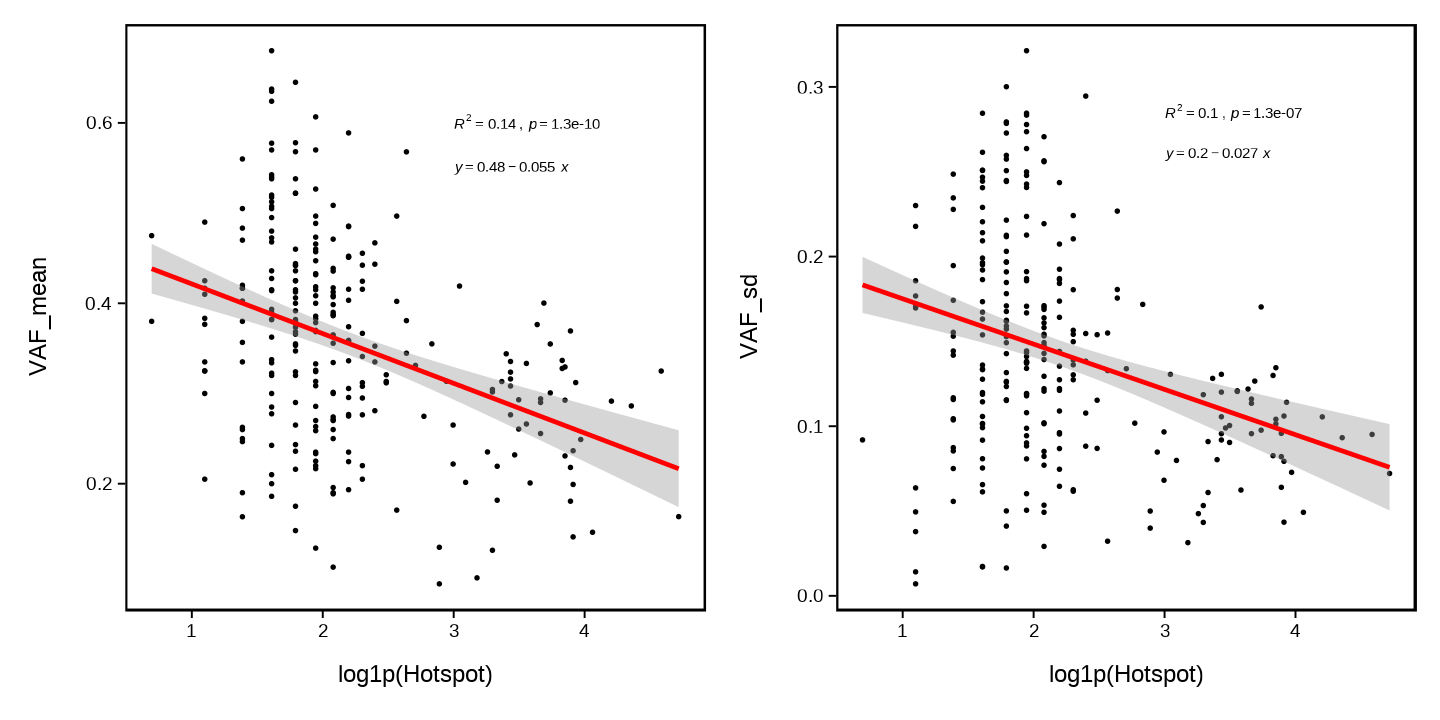

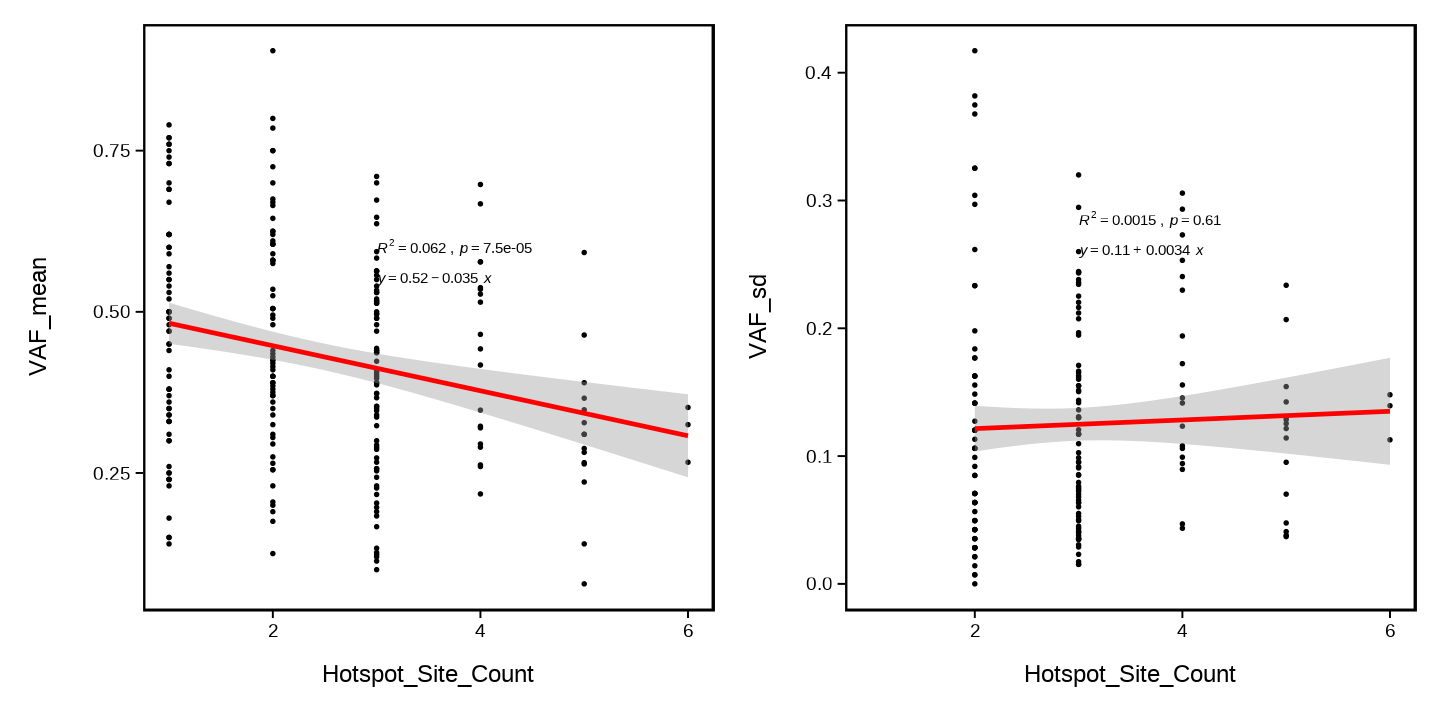

In [261]:
setfig( 12, 6 )

COAD.HotspotMutation_With_VAF_Purity %>% 
    ggplot( ., aes( log1p(Hotspot), VAF_mean ) ) + geom_point( size = .5 ) + 
        geom_smooth( method = "lm", se=TRUE, color="red", formula = y ~ x) + 
        stat_cor( label.x = 3, label.y = .6, aes(label = paste(..rr.label.., ..p.label.., sep = "~`,`~"))) + stat_regline_equation( label.x = 3, label.y = .55 ) +
        theme_linedraw( base_size = 18 ) + theme( panel.grid.major = element_blank(), panel.grid.minor = element_blank() ) |
COAD.HotspotMutation_With_VAF_Purity %>% 
    ggplot( ., aes( log1p(Hotspot), VAF_sd ) ) + geom_point( size = .5 ) + 
        geom_smooth( method = "lm", se=TRUE, color="red", formula = y ~ x) + 
        stat_cor( label.x = 3, label.y = .285, aes(label = paste(..rr.label.., ..p.label.., sep = "~`,`~"))) + stat_regline_equation( label.x = 3, label.y = .26 ) +
        theme_linedraw( base_size = 18 ) + theme( panel.grid.major = element_blank(), panel.grid.minor = element_blank() )  

COAD.HotspotMutation_With_VAF_Purity_HotspotSites %>% 
    ggplot( ., aes( Hotspot_Site_Count, VAF_mean ) ) + geom_point( size = .5 ) + 
        geom_smooth( method = "lm", se=TRUE, color="red", formula = y ~ x) + 
        stat_cor( label.x = 3, label.y = .6, aes(label = paste(..rr.label.., ..p.label.., sep = "~`,`~"))) + stat_regline_equation( label.x = 3, label.y = .55 ) +
        theme_linedraw( base_size = 18 ) + theme( panel.grid.major = element_blank(), panel.grid.minor = element_blank() ) |
COAD.HotspotMutation_With_VAF_Purity_HotspotSites %>% 
    ggplot( ., aes( Hotspot_Site_Count, VAF_sd ) ) + geom_point( size = .5 ) + 
        geom_smooth( method = "lm", se=TRUE, color="red", formula = y ~ x) + 
        stat_cor( label.x = 3, label.y = .285, aes(label = paste(..rr.label.., ..p.label.., sep = "~`,`~"))) + stat_regline_equation( label.x = 3, label.y = .26 ) +
        theme_linedraw( base_size = 18 ) + theme( panel.grid.major = element_blank(), panel.grid.minor = element_blank() )  

In [265]:
COAD.HotspotMutation_With_VAF_Purity_HotspotSites.tmp <- COAD.HotspotMutation_With_VAF_Purity_HotspotSites %>% drop_na( Hotspot_Site_Count, VAF_mean, microenvironment.score, immune.score )

cor(COAD.HotspotMutation_With_VAF_Purity_HotspotSites.tmp$Hotspot_Site_Count, COAD.HotspotMutation_With_VAF_Purity_HotspotSites.tmp$VAF_mean )
cor(COAD.HotspotMutation_With_VAF_Purity_HotspotSites.tmp$Hotspot_Site_Count, COAD.HotspotMutation_With_VAF_Purity_HotspotSites.tmp$microenvironment.score)
cor(COAD.HotspotMutation_With_VAF_Purity_HotspotSites.tmp$Hotspot_Site_Count, COAD.HotspotMutation_With_VAF_Purity_HotspotSites.tmp$immune.score)

[1] -0.249797

[1] 0.03182522

[1] 0.05185121

In [187]:
COAD.HotspotMutation_With_VAF_Purity.tmp <- COAD.HotspotMutation_With_VAF_Purity %>% drop_na( ploidy )
cor(COAD.HotspotMutation_With_VAF_Purity.tmp$ploidy, COAD.HotspotMutation_With_VAF_Purity.tmp$Hotspot)

[1] -0.3239149

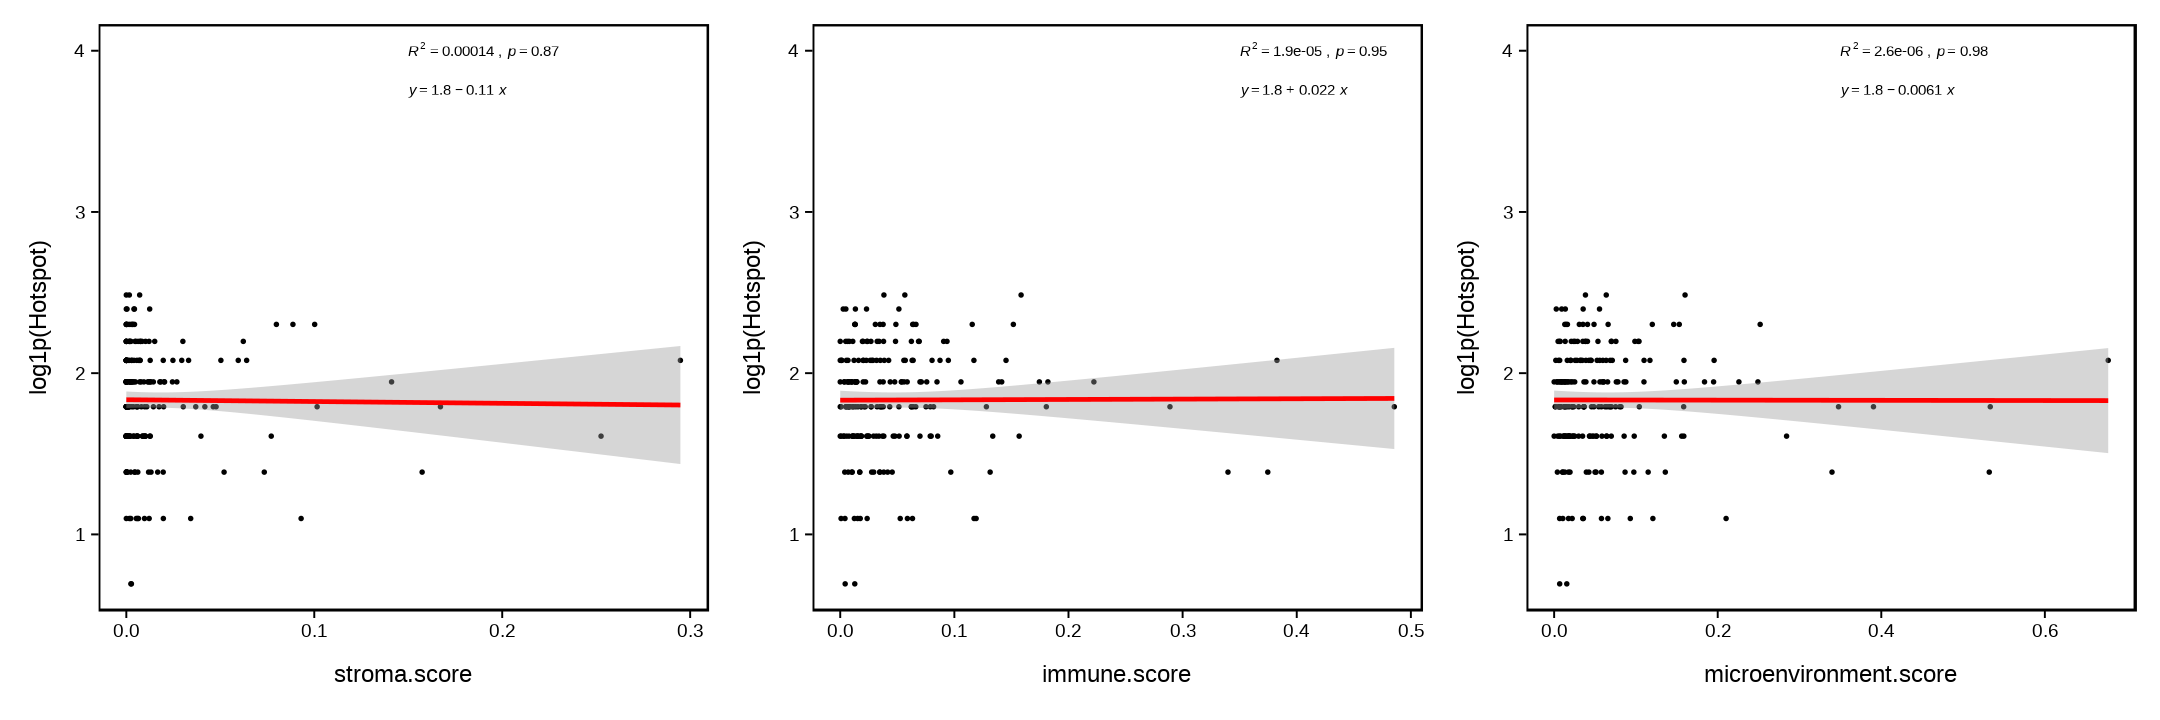

In [225]:
setfig( 18, 6 )

COAD.HotspotMutation_With_VAF_Purity %>% filter( log1p(Hotspot)<=2.5 ) %>%
    ggplot( ., aes( stroma.score, log1p(Hotspot) ) ) + geom_point( size = .5 ) +
        geom_smooth( method = "lm", se=TRUE, color="red", formula = y ~ x) +
        stat_cor( label.x = .15, label.y = 4, aes(label = paste(..rr.label.., ..p.label.., sep = "~`,`~"))) + stat_regline_equation( label.x = .15, label.y = 3.75 ) +
        theme_linedraw( base_size = 18 ) + theme( panel.grid.major = element_blank(), panel.grid.minor = element_blank() ) |
COAD.HotspotMutation_With_VAF_Purity %>% filter( log1p(Hotspot)<=2.5 ) %>%
    ggplot( ., aes( immune.score, log1p(Hotspot) ) ) + geom_point( size = .5 ) +
        geom_smooth( method = "lm", se=TRUE, color="red", formula = y ~ x) +
        stat_cor( label.x = .35, label.y = 4, aes(label = paste(..rr.label.., ..p.label.., sep = "~`,`~"))) + stat_regline_equation( label.x = .35, label.y = 3.75 ) +
        theme_linedraw( base_size = 18 ) + theme( panel.grid.major = element_blank(), panel.grid.minor = element_blank() ) |
COAD.HotspotMutation_With_VAF_Purity %>% filter( log1p(Hotspot)<=2.5 ) %>%
    ggplot( ., aes( microenvironment.score, log1p(Hotspot) ) ) + geom_point( size = .5 ) +
        geom_smooth( method = "lm", se=TRUE, color="red", formula = y ~ x) +
        stat_cor( label.x = .35, label.y = 4, aes(label = paste(..rr.label.., ..p.label.., sep = "~`,`~"))) + stat_regline_equation( label.x = .35, label.y = 3.75 ) +
        theme_linedraw( base_size = 18 ) + theme( panel.grid.major = element_blank(), panel.grid.minor = element_blank() )

### High and low microenvironment - not used

In [234]:
High.Microenvironment.samples <- COAD.HotspotMutation_With_VAF_Purity %>% filter( microenvironment.score>=.2 ) %>% drop_na() %>% .$sample
Low.Microenvironment.High.VAF.samples <- COAD.HotspotMutation_With_VAF_Purity %>% filter( microenvironment.score<.1, VAF_mean>.5 ) %>% drop_na() %>% .$sample

High.Microenvironment.samples %>% length
Low.Microenvironment.High.VAF.samples %>% length

COAD.SiteMutations.HighTME <- COAD.SiteMutations %>% filter( effect!="Silent", gene %in% Hotspot_Genes ) %>% mutate( DNA_VAF = as.numeric(DNA_VAF) ) %>% filter( sample %in% High.Microenvironment.samples )
COAD.SiteMutations.LowTME <- COAD.SiteMutations %>% filter( effect!="Silent", gene %in% Hotspot_Genes ) %>% mutate( DNA_VAF = as.numeric(DNA_VAF) ) %>% filter( sample %in% Low.Microenvironment.High.VAF.samples )

[1] 22

[1] 28

In [240]:
COAD.Clinical[ High.Microenvironment.samples, ] %>% .$CDE_ID_3226963 %>% table %>% as.data.frame

.,Freq
<fct>,<int>
,1
MSI-H,9
MSI-L,4
MSS,8


                Df Sum Sq Mean Sq F value  Pr(>F)   
CDE_ID_3226963   2 0.1214 0.06069   6.045 0.00272 **
Residuals      256 2.5703 0.01004                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

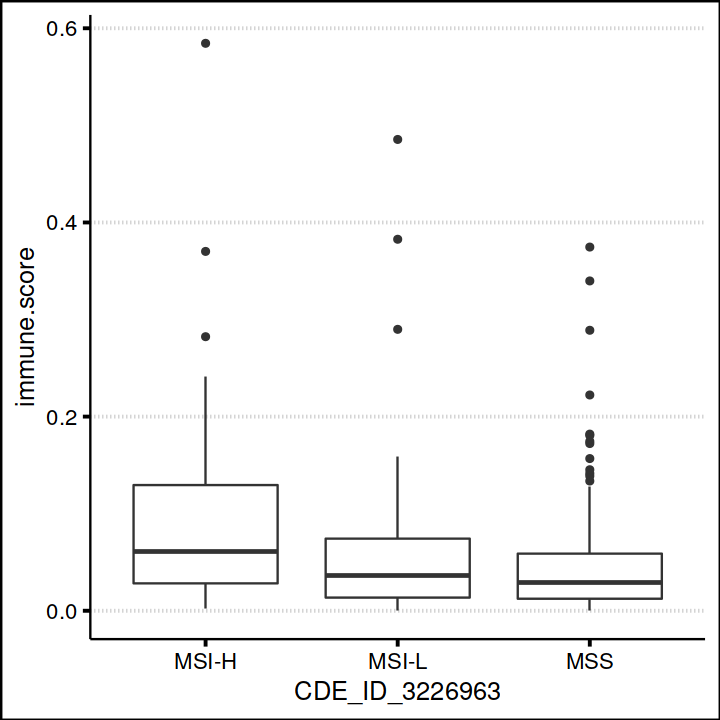

In [255]:
setfig( 6, 6 )

COAD.HotspotMutation_With_VAF_Purity.temp1 <- COAD.HotspotMutation_With_VAF_Purity %>% right_join( COAD.Clinical %>% filter( CDE_ID_3226963 %in% c("MSI-H","MSI-L","MSS") ) %>% dplyr::select( sampleID, CDE_ID_3226963 ), by = c("sample"="sampleID") )

COAD.HotspotMutation_With_VAF_Purity.temp1 %>% ggplot( ., aes(CDE_ID_3226963,immune.score) ) + geom_boxplot() + theme_clean( base_size = 18 )

res.aov <- aov(microenvironment.score ~ CDE_ID_3226963, data = COAD.HotspotMutation_With_VAF_Purity.temp1)
summary(res.aov)

In [249]:
head( COAD.HotspotMutation_With_VAF_Purity.temp1 )

,sample,count,VAF_mean,VAF_sd,purity,ploidy,Cancer DNA fraction,log10 of count,immune.score,stroma.score,microenvironment.score,CDE_ID_3226963
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,TCGA-CM-6166-01,12,0.4083333,0.13776352,0.73,2.27,0.76,1.0791812,2.333196e-18,5.820693e-20,2.391403e-18,MSS
2,TCGA-DM-A1D6-01,5,0.5400000,0.19912308,0.90,1.90,0.89,0.6989700,1.632162e-18,1.195422e-18,2.827584e-18,MSS
3,TCGA-DM-A282-01,6,0.3533333,0.05006662,0.79,2.00,0.79,0.7781513,6.861787e-04,7.447924e-04,1.430971e-03,MSS
4,TCGA-AD-A5EK-01,5,0.5780000,0.25063918,0.84,2.54,0.87,0.6989700,5.541368e-18,1.464862e-03,1.464862e-03,MSS
5,TCGA-G4-6298-01,7,0.3900000,0.07702813,0.60,1.98,0.60,0.8450980,1.109138e-03,9.081409e-04,2.017278e-03,MSI-L
6,TCGA-AD-6889-01,42,0.4002381,0.12659688,0.88,2.00,0.88,1.6232493,2.187524e-03,5.591199e-19,2.187524e-03,MSI-H
